In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import gsd.hoomd
from sklearn import cluster as cl
import scipy as sci

In [31]:
plt.style.use('rates_plot.mplstyle')

In [32]:
def unwrap_positions(positions, box, prev_positions=None):
    """
    Unwrap particle positions in a periodic box.
    
    Parameters:
    positions (np.ndarray): Particle positions (N x 3).
    box (np.ndarray): Box dimensions (3, corresponding to Lx, Ly, Lz).
    prev_positions (np.ndarray): Previous positions of particles (N x 3).
    
    Returns:
    np.ndarray: Unwrapped positions.
    """
    unwrapped_positions = np.copy(positions)
    box_lengths = np.array([box[0], box[1], box[2]])
    
    if prev_positions is not None:
        delta = positions - prev_positions
        delta -= np.round(delta / box_lengths) * box_lengths
        unwrapped_positions = prev_positions + delta
    
    return unwrapped_positions

def wrap_positions(positions, box):
    """
    Wrap particle positions back into the periodic box.
    
    Parameters:
    positions (np.ndarray): Particle positions (N x 3).
    box (np.ndarray): Box dimensions (3, corresponding to Lx, Ly, Lz).
    
    Returns:
    np.ndarray: Wrapped positions.
    """
    box_lengths = np.array([box[0], box[1], box[2]])
    wrapped_positions = positions - np.floor(positions / box_lengths + 0.5) * box_lengths
    
    return wrapped_positions

def center_trajectory(input_file, output_file, therm=0):
    # Open the input GSD file
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        # Create the output GSD file
        with gsd.hoomd.open(output_file, 'wb') as output_gsd:
            # Initialize the previous positions array
            prev_positions = None
            box = input_gsd[0].configuration.box[:3]  # Get box dimensions (Lx, Ly, Lz)
            
            for frame in tqdm(input_gsd[therm:]):
                positions = frame.particles.position  # Get particle positions

                # Unwrap positions
                unwrapped_positions = unwrap_positions(positions, box, prev_positions)

                # Update prev_positions for the next frame
                prev_positions = np.copy(unwrapped_positions)
                
                # Shift positions to center the center of mass in the box
                centered_positions = unwrapped_positions - np.mean(unwrapped_positions, axis=0)

                # Wrap positions back into the box
                wrapped_positions = wrap_positions(centered_positions, box)

                # Update positions in the frame
                frame.particles.position = wrapped_positions

                # Append the frame to the output GSD file
                output_gsd.append(frame)
             

            
            
def process_trajectory(input_file, output_file, diss_time, therm=0, center_id=30800):
    # Open the input GSD file
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        # Create the output GSD file
        with gsd.hoomd.open(output_file, 'wb') as output_gsd:
            # Initialize the previous positions array
            prev_positions = None
            box = input_gsd[0].configuration.box[:3]  # Get box dimensions (Lx, Ly, Lz)
            
            for i,frame in enumerate(tqdm(input_gsd[therm:])):
                positions = frame.particles.position  # Get particle positions

                # Unwrap positions
                unwrapped_positions = unwrap_positions(positions, box, prev_positions)

                # Update prev_positions for the next frame
                prev_positions = np.copy(unwrapped_positions)
                
                # Shift positions to center the center of mass in the box
                if i<diss_time:
                    centered_positions = unwrapped_positions - np.mean(unwrapped_positions, axis=0)
                else:
                    centered_positions = unwrapped_positions - unwrapped_positions[center_id]
                    
                # Wrap positions back into the box
                wrapped_positions = wrap_positions(centered_positions, box)

                # Update positions in the frame
                frame.particles.position = wrapped_positions

                # Append the frame to the output GSD file
                output_gsd.append(frame)

In [21]:
therm = 0
process_trajectory(input_file, output_file, therm)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:30<00:00,  7.13it/s]


### Clustering with DBSCAN

In [3]:
def nphospho_in_time(input_file, times):
    n_phospho_arr = np.zeros(len(times))
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(times):
            frame = input_gsd[int(tt)]
            n_phospho_arr[i] = np.sum(frame.particles.typeid==20)
            
    return n_phospho_arr

In [4]:
def condensate_size_from_dbscan(frame, n_enz, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    
    if np.array_equal(labels[30800:30800+n_enz],[condensate_idx]*n_enz):
        return np.max(counts)
    else:
        print(labels[30800:30800+n_enz],[condensate_idx])

        return 0

In [5]:
def chains_in_condensate(input_file, times, n_enz, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    n_phospho_arr = np.zeros(len(times))
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_p_condensate = condensate_size_from_dbscan(frame, n_enz, eps, min_sample)
            n_chains_arr[i] = n_p_condensate/154.
            
            n_phospho_arr[i] = np.sum(frame.particles.typeid==20)
            
    return n_chains_arr, n_phospho_arr

In [6]:
def condensate_size_from_dbscan_pbc(frame, box, eps=1.0, min_sample=2):
    
    positions = frame.particles.position

    # Compute square distance matrix for all the selected particles
    total = []
    for d in range(positions.shape[1]):
        # Find all the 1-D distances
        pd = sci.spatial.distance.pdist(positions[:, d].reshape(positions.shape[0], 1))
        # Apply PBC
        pd[pd > box[d]*0.5] -= box[d]
        try:
            # Sum up individual components
            total += pd**2
        except Exception as e:
            # or define the sum variable if not defined previously
            total = pd ** 2
    # Transform the condensed distance matrix
    total = np.sqrt(total)
    # Transform into a square distance matrix
    square = sci.spatial.distance.squareform(total)
    print('hello')
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(square)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = np.argmax(counts)
    
    if np.array_equal(labels[30800:30803],[values[condensate_idx]]*3):
        return counts[condensate_idx]
    else:
        print(labels[30800:30803],[condensate_idx])

        return 0

In [7]:
def chains_in_condensate_pbc(input_file, times, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        simBox = input_gsd[0].configuration.box # the production runs are NVT

        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_p_condensate = condensate_size_from_dbscan_pbc(frame, simBox, eps, min_sample)
            n_chains_arr[i] = n_p_condensate/154.
    return n_chains_arr

In [8]:
def condensate_helix_size_from_dbscan(frame, n_enz, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    labels_tdp = np.append(labels[:28400], labels[28400+n_enz:28400+n_enz+13*200])
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    
    if np.array_equal(labels[28400:28400+n_enz],[condensate_idx]*n_enz):
        return np.max(counts)
    else:
        print(labels[28400:28400+n_enz],[condensate_idx])

        return 0

In [9]:
def chains_in_condensate_helix(input_file, times, n_enz, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    n_phospho_arr = np.zeros(len(times))
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_p_condensate = condensate_helix_size_from_dbscan(frame, n_enz, eps, min_sample)
            n_chains_arr[i] = n_p_condensate/154.
            
            n_phospho_arr[i] = np.sum(frame.particles.typeid==20)
            
    return n_chains_arr, n_phospho_arr

In [10]:
def enzyme_in_condensate_from_dbscan(frame, n_enz, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]

    return np.sum(labels[30800:30800+n_enz]==np.array([condensate_idx]*n_enz))

In [11]:
def enzymes_in_condensate(input_file, times, n_enz, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_chains_arr[i] = enzyme_in_condensate_from_dbscan(frame, n_enz, eps, min_sample)

    return n_chains_arr

In [12]:
def pSer_dilute_from_dbscan(frame, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    type_ids = frame.particles.typeid[:30800]
    
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    dilute_ids = type_ids[ labels[:30800] != condensate_idx ]
    
    if len(dilute_ids)%154 == 0:
        n_chains_dilute = int( len(dilute_ids)/154 )
        print(f'n chains dilute: {n_chains_dilute}')
        pSer_per_chain = np.array([ np.sum( dilute_ids[154*ichain:154*(ichain+1)]==20 ) for ichain in range(n_chains_dilute) ])
    else:
        raise ValueError(f'Some chains are split between condensate and dilute! {len(dilute_ids)} monomers in dilute.')
             
    return pSer_per_chain
    

In [13]:
def pSer_dilute(input_file, times, eps=1.0, min_sample=2):

    mu_pSerdil_arr = np.zeros(len(times))
    sigma_pSerdil_arr = np.zeros(len(times))
    n_chainsdil_arr = np.zeros(len(times))
    pSerdil_l = []
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            print(tt)
            frame = input_gsd[int(tt)]
            pSer_per_dilute_chain = pSer_dilute_from_dbscan(frame, eps, min_sample)
            n_chainsdil_arr[i] = len(pSer_per_dilute_chain)
            mu_pSerdil_arr[i] = np.mean(pSer_per_dilute_chain)
            sigma_pSerdil_arr[i] = np.std(pSer_per_dilute_chain)
            pSerdil_l.append(pSer_per_dilute_chain)
                        
    return pSerdil_l, mu_pSerdil_arr, sigma_pSerdil_arr, n_chainsdil_arr

In [14]:
def radial_distribution_pSer_from_dbscan(frame, bin_edges, nenz, norm_particles, eps, min_sample):
    
    mask_R = np.array([True]*frame.particles.N)
    mask_R[30800:30800+nenz] = False
    
    positions = frame.particles.position[mask_R]
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels, return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    cond_pos = positions[ labels == condensate_idx ]
    tdp_pos = positions[:30800]
    center_cond_pos = np.mean(cond_pos, axis=0)
    
    tdp_typeid = frame.particles.typeid[:30800] 
    ser_pos = tdp_pos[ tdp_typeid == 15 ]
    pser_pos = tdp_pos[ tdp_typeid == 20 ]
    ser_dists = np.linalg.norm(ser_pos - center_cond_pos, axis=1)
    pser_dists = np.linalg.norm(pser_pos - center_cond_pos, axis=1)
    
    counts_ser, _ = np.histogram( ser_dists, bin_edges )
    counts_ser = counts_ser.astype(float)
    counts_pser, _ = np.histogram( pser_dists, bin_edges )
    counts_pser = counts_pser.astype(float)
    
    if norm_particles:
        particles_dists = np.linalg.norm(positions - center_cond_pos, axis=1)
        counts_particles, _ = np.histogram( particles_dists, bin_edges )
        counts_ser[counts_ser!=0] /= counts_particles[counts_ser!=0]
        counts_pser[counts_pser!=0] /= counts_particles[counts_pser!=0]
        
    return counts_ser, counts_pser

In [15]:
def radial_distribution_pSer(input_file, times, bin_edges, nenz=1, norm_particles=False, eps=1.0, min_sample=2):

    counts_ser = np.zeros(len(bin_edges)-1)
    counts_pser = np.zeros(len(bin_edges)-1)
    
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            tmp_counts_ser, tmp_counts_pser = radial_distribution_pSer_from_dbscan(frame, bin_edges, nenz, norm_particles,  eps, min_sample)
            counts_ser += tmp_counts_ser
            counts_pser += tmp_counts_pser
            
    counts_ser /= len(times)
    counts_pser /= len(times)
    
    if not norm_particles:
        bin_volumes = (4*np.pi/3)*np.array([bin_edges[i+1]**3 - bin_edges[i]**3 for i in range(len(bin_edges)-1)])
        counts_ser /= bin_volumes
        counts_pser /= bin_volumes
    
    return counts_ser, counts_pser

In [16]:
def radial_distribution_enzyme_from_dbscan(frame, bin_edges, nenz, norm_particles, eps, min_sample):
    
    mask_R = np.array([True]*frame.particles.N)
    mask_R[30800:30800+nenz] = False
    
    positions = frame.particles.position[mask_R]
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels, return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    cond_pos = positions[ labels == condensate_idx ]
    center_cond_pos = np.mean(cond_pos, axis=0)

    enz_cond_pos = positions[30800:][ labels[30800:] == condensate_idx ]
    enz_dists = np.linalg.norm(enz_cond_pos - center_cond_pos, axis=1)
    print(len(enz_cond_pos)/292)
    
    counts_enz, _ = np.histogram( enz_dists, bin_edges )
    counts_enz = counts_enz.astype(float)
    
    if norm_particles:
        particles_dists = np.linalg.norm(positions - center_cond_pos, axis=1)
        counts_particles, _ = np.histogram( particles_dists, bin_edges )
        counts_enz[counts_enz!=0] /= counts_particles[counts_enz!=0]
        
    return counts_enz

In [17]:
def radial_distribution_enzyme(input_file, times, bin_edges, nenz=1, norm_particles=False, eps=1.0, min_sample=2):

    counts_enzyme = np.zeros(len(bin_edges)-1)    
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            tmp_counts = radial_distribution_enzyme_from_dbscan(frame, bin_edges, nenz, norm_particles, eps, min_sample)
            counts_enzyme += tmp_counts
            
    counts_enzyme /= len(times)

    if not norm_particles:
        bin_volumes = (4*np.pi/3)*np.array([bin_edges[i+1]**3 - bin_edges[i]**3 for i in range(len(bin_edges)-1)])
        counts_enzyme /= bin_volumes
    
    return counts_enzyme

In [18]:
def radial_distribution_full_enzyme_from_dbscan(frame, bin_edges, nenz, norm_particles, eps, min_sample):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels, return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    cond_pos = positions[ labels == condensate_idx ]
    center_cond_pos = np.mean(cond_pos, axis=0)

    enz_cond_pos = positions[30800+nenz*122:][ labels[30800+nenz*122:] == condensate_idx ]
    enz_dists = np.linalg.norm(enz_cond_pos - center_cond_pos, axis=1)
    tail_cond_pos = positions[30800:30800+nenz*122][ labels[30800:30800+nenz*122] == condensate_idx ]
    tail_dists = np.linalg.norm(tail_cond_pos - center_cond_pos, axis=1)
    
    counts_enz, _ = np.histogram( enz_dists, bin_edges )
    counts_enz = counts_enz.astype(float)
    counts_tail, _ = np.histogram( tail_dists, bin_edges )
    counts_tail = counts_tail.astype(float)
    
    if norm_particles:
        particles_dists = np.linalg.norm(positions - center_cond_pos, axis=1)
        counts_particles, _ = np.histogram( particles_dists, bin_edges )
        counts_enz[counts_enz!=0] /= counts_particles[counts_enz!=0]
        counts_tail[counts_tail!=0] /= counts_particles[counts_tail!=0]
        
    return counts_enz, counts_tail

In [19]:
def radial_distribution_full_enzyme(input_file, times, bin_edges, nenz=1, norm_particles=False, eps=1.0, min_sample=2):

    counts_enzyme = np.zeros(len(bin_edges)-1)    
    counts_tail = np.zeros(len(bin_edges)-1)    
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            tmp_counts,tmp_counts_tail = radial_distribution_full_enzyme_from_dbscan(frame, bin_edges, nenz, norm_particles, eps, min_sample)
            counts_enzyme += tmp_counts
            counts_tail += tmp_counts_tail
            
    counts_enzyme /= len(times)
    counts_tail /= len(times)

    if not norm_particles:
        bin_volumes = (4*np.pi/3)*np.array([bin_edges[i+1]**3 - bin_edges[i]**3 for i in range(len(bin_edges)-1)])
        counts_enzyme /= bin_volumes
        counts_tail /= bin_volumes
    
    return counts_enzyme, counts_tail

In [20]:
def distance_particle_from_condensate_dbscan(frame, part_idx, eps, min_sample):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels, return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    cond_pos = positions[ labels == condensate_idx ]
    center_cond_pos = np.mean(cond_pos, axis=0)

    part_pos = positions[part_idx]
    dist = np.linalg.norm(part_pos - center_cond_pos)
            
    return dist

In [21]:
def distance_particle_from_condensate(input_file, times, part_idx, eps=1.0, min_sample=2):

    dist = np.zeros(len(times))    
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            tmp_dist = distance_particle_from_condensate_dbscan(frame, part_idx, eps, min_sample)
            dist[i] = tmp_dist
                
    return dist

In [45]:
step = 20
times = np.arange(200,2500,step, dtype=int)-1

step = 10
times_sh = np.arange(0,500,step, dtype=int)

step=50
times_dis = np.arange(500,2500,step, dtype=int)

step = 20
times_np = np.arange(0,2450,step, dtype=int)-1
len(times_np)

123

## Dissolution of condensate

In [48]:
nc_1ck1d = np.zeros(len(times)-1)
np_1ck1d = np.zeros(len(times)-1)
nc_3ck1d = np.zeros(len(times)-1)
np_3ck1d = np.zeros(len(times)-1)
nc_5ck1d = np.zeros(len(times)-1)
np_5ck1d = np.zeros(len(times)-1)

for i in range(1,5):
    tmp_nc_1ck1d, tmp_np_1ck1d = chains_in_condensate(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times[:-1], 1)
    tmp_nc_3ck1d, tmp_np_3ck1d = chains_in_condensate(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times[:-1], 3)
    tmp_nc_5ck1d, tmp_np_5ck1d = chains_in_condensate(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times[:-1], 5)
    nc_1ck1d += tmp_nc_1ck1d
    np_1ck1d += tmp_np_1ck1d
    nc_3ck1d += tmp_nc_3ck1d
    np_3ck1d += tmp_np_3ck1d
    nc_5ck1d += tmp_nc_5ck1d
    np_5ck1d += tmp_np_5ck1d
    
nc_1ck1d /= 4
np_1ck1d /= 4
nc_3ck1d /= 4
np_3ck1d /= 4
nc_5ck1d /= 4
np_5ck1d /= 4

2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:45<00:00,  2.48it/s]


2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:43<00:00,  2.62it/s]


2500


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 105/114 [00:40<00:02,  3.41it/s]

[ 4  4  4  4 72] [4]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 106/114 [00:40<00:02,  3.54it/s]

[ 4  4  4 39 52] [4]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 107/114 [00:40<00:01,  3.65it/s]

[20 20 20 41 53] [20]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 108/114 [00:41<00:01,  3.73it/s]

[54 23 54 13  8] [13]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 109/114 [00:41<00:01,  3.81it/s]

[16 17 16 36  7] [16]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 110/114 [00:41<00:01,  3.86it/s]

[17 27 17 24 27] [27]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 111/114 [00:41<00:00,  3.89it/s]

[ 1  7  1 33  7] [7]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 112/114 [00:42<00:00,  3.83it/s]

[18 17 18 27 17] [27]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 113/114 [00:42<00:00,  3.86it/s]

[16 16 16 43 16] [16]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:42<00:00,  2.67it/s]


[1 1 1 4 1] [1]
2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:46<00:00,  2.44it/s]


2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:46<00:00,  2.46it/s]


2500


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 102/114 [00:38<00:03,  3.44it/s]

[ 1 25 24 25 25] [24]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 103/114 [00:38<00:03,  3.41it/s]

[1 8 8 8 8] [8]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 104/114 [00:38<00:02,  3.37it/s]

[30  8  8  8  8] [8]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 105/114 [00:39<00:02,  3.41it/s]

[43 13 13 13 13] [13]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 107/114 [00:39<00:01,  3.51it/s]

[23 23 23 34 23] [23]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 108/114 [00:40<00:01,  3.46it/s]

[ 3  3  3 18  3] [3]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 109/114 [00:40<00:01,  3.36it/s]

[ 2  2  2 35  2] [2]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 110/114 [00:40<00:01,  3.42it/s]

[44 44 44 16 44] [44]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 111/114 [00:41<00:00,  3.38it/s]

[12 12 12  3 12] [12]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 112/114 [00:41<00:00,  3.39it/s]

[11 11 11 18 11] [11]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 113/114 [00:41<00:00,  3.45it/s]

[19 19 19 41 19] [19]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.72it/s]


[17 17 17 37 17] [17]
2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:46<00:00,  2.48it/s]


2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:45<00:00,  2.49it/s]


2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:41<00:00,  2.73it/s]


2500


  1%|█▌                                                                                                                                                                            | 1/114 [00:00<00:45,  2.48it/s]

[1] [0]


  2%|███                                                                                                                                                                           | 2/114 [00:00<00:45,  2.48it/s]

[1] [0]


  4%|██████                                                                                                                                                                        | 4/114 [00:01<00:43,  2.51it/s]

[1] [0]


  4%|███████▋                                                                                                                                                                      | 5/114 [00:01<00:43,  2.51it/s]

[1] [0]


  5%|█████████▏                                                                                                                                                                    | 6/114 [00:02<00:42,  2.51it/s]

[1] [0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:46<00:00,  2.46it/s]


2500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:45<00:00,  2.51it/s]


2500


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 100/114 [00:36<00:04,  3.42it/s]

[ 0 87  0  0  0] [0]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 101/114 [00:36<00:03,  3.40it/s]

[  0 122   0   0   0] [0]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 102/114 [00:37<00:03,  3.46it/s]

[14 22 14 14 14] [14]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 103/114 [00:37<00:03,  3.46it/s]

[18 15 18 18 18] [18]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 104/114 [00:37<00:02,  3.44it/s]

[35 62 35 35 35] [35]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:40<00:00,  2.80it/s]


In [80]:
file_helix = ''

nc_5ck1d_helix = np.zeros(len(times)-1)
np_5ck1d_helix = np.zeros(len(times)-1)

for i in range(1,6):
    tmp_nc_5ck1d_helix, tmp_np_5ck1d_helix = chains_in_condensate_helix(file_helix+f'sim{i}_5-folded-ck1d_200-helix-tdp43_v1.7.0_helix_dump_processed.gsd', times[:-1], 5)
    nc_5ck1d_helix += tmp_nc_5ck1d_helix
    np_5ck1d_helix += tmp_np_5ck1d_helix
    
nc_5ck1d_helix /= 5
np_5ck1d_helix /= 5

2500


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 97/114 [00:43<00:05,  3.11it/s]

[ 7 14  7  7  7] [7]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 98/114 [00:44<00:04,  3.22it/s]

[ 54 131  54  54  54] [54]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/114 [00:44<00:04,  3.23it/s]

[ 61 173  61  61  61] [61]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 100/114 [00:44<00:04,  3.33it/s]

[  7 161   7   7   7] [7]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 101/114 [00:45<00:03,  3.32it/s]

[  6 151   6   6   6] [6]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 102/114 [00:45<00:03,  3.24it/s]

[ 5 17  5  5  5] [5]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 103/114 [00:45<00:03,  3.16it/s]

[ 4 14  4  4  4] [4]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 104/114 [00:46<00:03,  3.12it/s]

[ 3 78  3  3  3] [3]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 105/114 [00:46<00:02,  3.16it/s]

[28 10 28 28 28] [28]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 106/114 [00:46<00:02,  3.23it/s]

[35 71 35 35 35] [35]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 107/114 [00:46<00:02,  3.26it/s]

[ 8 20  8  8  8] [8]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 108/114 [00:47<00:01,  3.33it/s]

[ 31 137  31  31  31] [31]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 112/114 [00:48<00:00,  3.58it/s]

[ 42 102  42  65 102] [42]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 113/114 [00:48<00:00,  3.39it/s]

[ 10 120  10  66 125] [49]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:48<00:00,  2.33it/s]


[10 85 10 86 48] [10]
2500


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 78/114 [00:36<00:10,  3.32it/s]

[ 5  5  5 27  5] [5]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 79/114 [00:36<00:10,  3.20it/s]

[ 7  7  7 24  7] [7]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 85/114 [00:38<00:08,  3.45it/s]

[  2   2   2   2 104] [2]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 86/114 [00:38<00:08,  3.45it/s]

[  4   4   4   4 132] [4]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 87/114 [00:39<00:07,  3.43it/s]

[16 16 16 16 20] [16]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 88/114 [00:39<00:07,  3.42it/s]

[ 2  2  2  2 25] [2]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 89/114 [00:39<00:07,  3.18it/s]

[19 19 19 19 15] [19]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 90/114 [00:40<00:07,  3.22it/s]

[ 0  0  0  0 44] [0]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 91/114 [00:40<00:06,  3.30it/s]

[ 9  9  9  9 12] [9]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 92/114 [00:40<00:06,  3.37it/s]

[20 20 20 20 50] [20]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 93/114 [00:41<00:06,  3.42it/s]

[73 73 73 73  9] [9]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 94/114 [00:41<00:06,  3.18it/s]

[ 6  6  6  6 13] [6]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 95/114 [00:41<00:05,  3.21it/s]

[10 10 10 10  1] [10]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 96/114 [00:41<00:05,  3.33it/s]

[5 5 5 5 0] [5]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 97/114 [00:42<00:05,  3.20it/s]

[22 22 22 22 78] [22]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 98/114 [00:42<00:05,  3.16it/s]

[ 2  2  2  2 66] [2]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 103/114 [00:44<00:03,  3.46it/s]

[3 3 3 3 3] [1]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 106/114 [00:44<00:02,  3.55it/s]

[ 9 15 15 15 15] [15]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 107/114 [00:45<00:01,  3.57it/s]

[50 59  9  9 63] [9]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 108/114 [00:45<00:01,  3.57it/s]

[ 84 113   6   6  30] [6]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 109/114 [00:45<00:01,  3.45it/s]

[24 89 14 14 45] [24]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 110/114 [00:46<00:01,  3.49it/s]

[ 9 48  9  9 11] [9]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 111/114 [00:46<00:00,  3.56it/s]

[12 94 12 12  6] [12]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 112/114 [00:46<00:00,  3.59it/s]

[ 9 34  9  9  3] [9]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 113/114 [00:46<00:00,  3.59it/s]

[ 2 49  2  2 12] [49]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:47<00:00,  2.42it/s]


[100  79 100 100  12] [100]
2500


  1%|█▌                                                                                                                                                                            | 1/114 [00:00<00:51,  2.17it/s]

[0 0 0 1 0] [0]


  2%|███                                                                                                                                                                           | 2/114 [00:01<00:57,  1.94it/s]

[0 0 0 1 0] [0]


  3%|████▌                                                                                                                                                                         | 3/114 [00:01<01:04,  1.72it/s]

[0 0 0 1 0] [0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:50<00:00,  2.27it/s]


2500


  1%|█▌                                                                                                                                                                            | 1/114 [00:00<00:51,  2.17it/s]

[0 1 0 0 0] [0]


  2%|███                                                                                                                                                                           | 2/114 [00:01<01:00,  1.85it/s]

[0 1 0 0 0] [0]


  3%|████▌                                                                                                                                                                         | 3/114 [00:01<01:03,  1.74it/s]

[0 1 0 0 0] [0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:50<00:00,  2.26it/s]


2500


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 97/114 [00:43<00:04,  3.50it/s]

[81 17 17 17 17] [17]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 98/114 [00:43<00:04,  3.52it/s]

[25  7  7  7  7] [7]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 99/114 [00:44<00:04,  3.55it/s]

[8 5 5 5 5] [5]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 100/114 [00:44<00:04,  3.49it/s]

[40  8  8  8  8] [8]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 101/114 [00:44<00:03,  3.52it/s]

[45 10 10 10 10] [10]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 102/114 [00:44<00:03,  3.54it/s]

[60  5  5  6  6] [6]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 103/114 [00:45<00:03,  3.58it/s]

[51  0  0  0  0] [0]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 104/114 [00:45<00:02,  3.57it/s]

[111   0   0   0   0] [0]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 105/114 [00:45<00:02,  3.56it/s]

[21  0  0  0  0] [0]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 106/114 [00:46<00:02,  3.57it/s]

[42  0  0  0  0] [0]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 107/114 [00:46<00:01,  3.57it/s]

[115   0   0   0   0] [0]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 108/114 [00:46<00:01,  3.54it/s]

[24  7  7  7  7] [7]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:48<00:00,  2.36it/s]


In [84]:
np.savetxt(file+'size_cond_1-folded-ck1d_multi-tdp43.txt', nc_1ck1d)
np.savetxt(file+'size_cond_3-folded-ck1d_multi-tdp43.txt', nc_3ck1d)
np.savetxt(file+'size_cond_5-folded-ck1d_multi-tdp43.txt', nc_5ck1d)
np.savetxt(file+'nphospho_1-folded-ck1d_multi-tdp43.txt', np_1ck1d)
np.savetxt(file+'nphospho_3-folded-ck1d_multi-tdp43.txt', np_3ck1d)
np.savetxt(file+'nphospho_5-folded-ck1d_multi-tdp43.txt', np_5ck1d)

np.savetxt(file_helix+'size_cond_5-folded-ck1d_200-helix-tdp43.txt', nc_5ck1d_helix)
np.savetxt(file_helix+'nphospho_5-folded-ck1d_200-helix-tdp43.txt', np_5ck1d_helix)


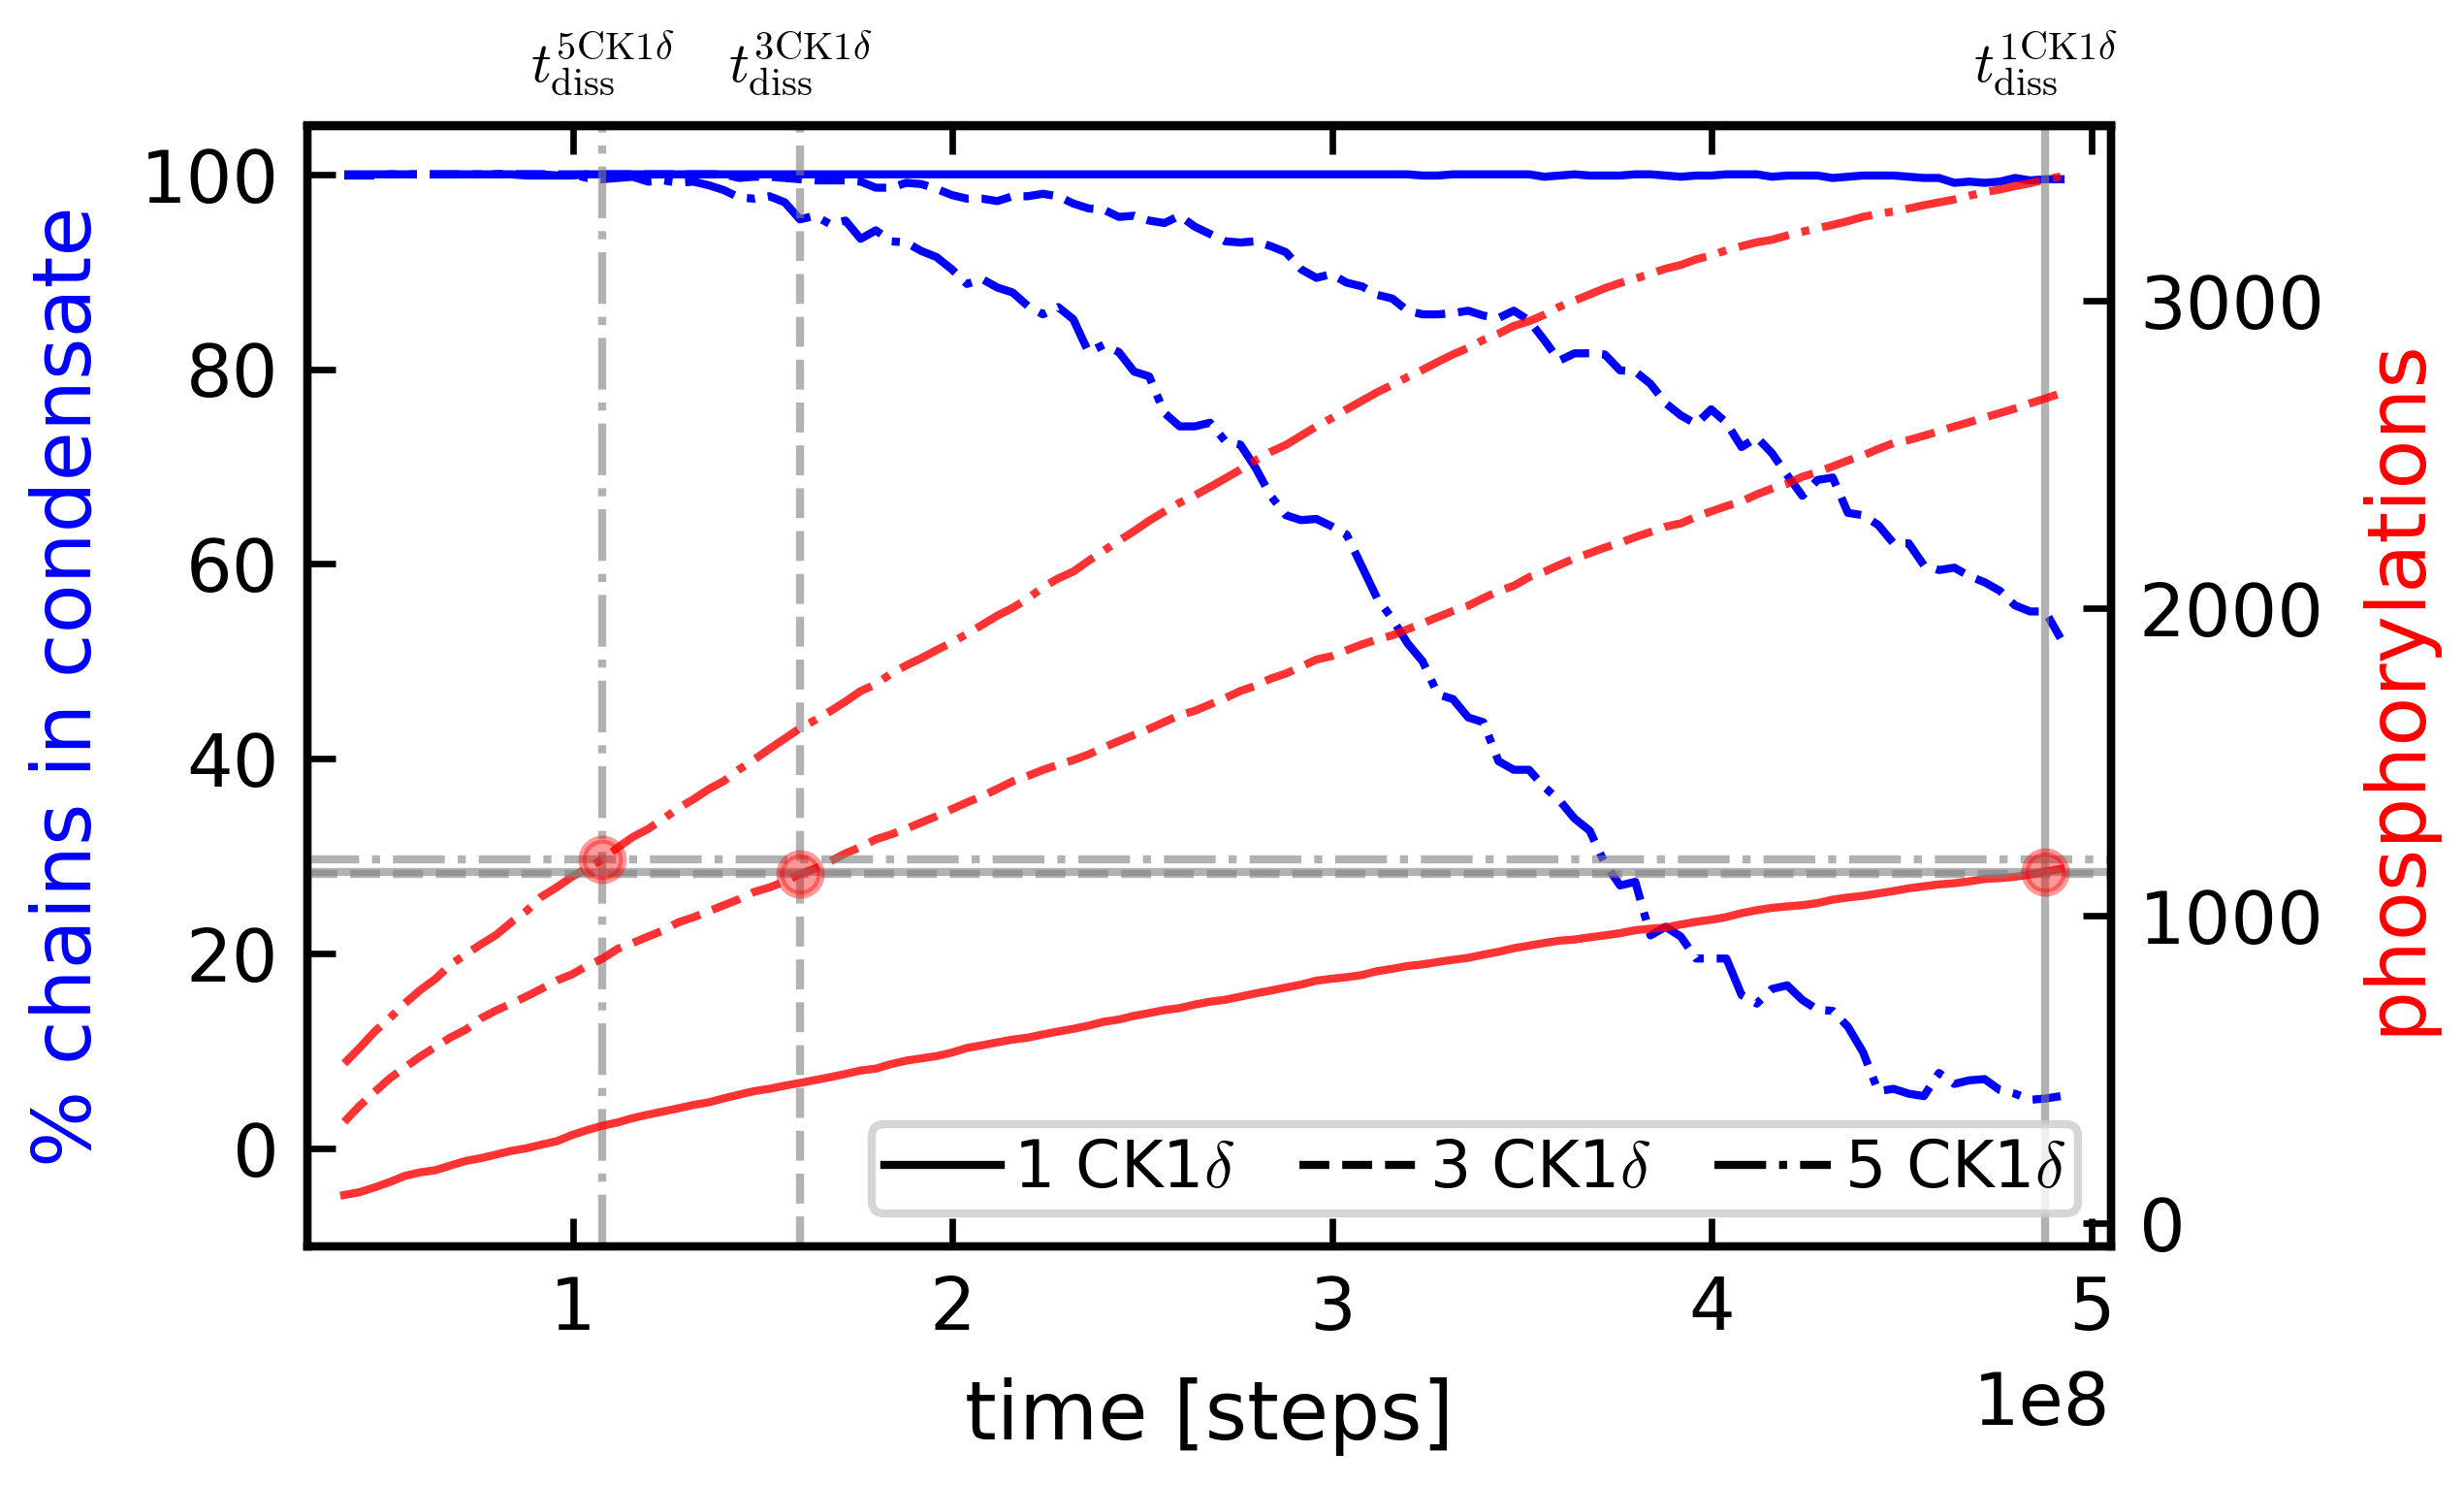

In [54]:
time_step = times*200000
td_1 = np.where(nc_1ck1d/200 == 0.995)[0][0]
td_3 = np.where(nc_3ck1d/200 == 0.995)[0][0]
td_5 = np.where(nc_5ck1d/200 == 0.995)[0][0]

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step[10:-1], nc_1ck1d[10:]/2, 'b')
ax1.plot(time_step[:-1], nc_3ck1d/2, 'b--')
ax1.plot(time_step[:-1], nc_5ck1d/2, 'b-.')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% chains in condensate', color='b')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k', label=r'1 CK1$\delta$')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k--', label=r'3 CK1$\delta$')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k-.', label=r'5 CK1$\delta$')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([time_step[td_1], time_step[td_3], time_step[td_5]], ['$t^\mathrm{1CK1\delta}_\mathrm{diss}$','$t^\mathrm{3CK1\delta}_\mathrm{diss}$','$t^\mathrm{5CK1\delta}_\mathrm{diss}$'], fontsize='x-small' )
secax.tick_params(direction='in', color='grey' , length=0)

ax1.vlines([time_step[td_1], time_step[td_3], time_step[td_5]],ymin=-10,ymax=105, ls=['-','--','-.'] ,color='grey', linewidth=1, alpha=0.6)
ax1.set_ylim((-10,105))

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step[:-1], np_1ck1d,  'r', alpha=0.8)
ax2.plot(time_step[:-1], np_3ck1d, 'r--', alpha=0.8)
ax2.plot(time_step[:-1], np_5ck1d, 'r-.', alpha=0.8)
ax2.set_ylabel('phosphorylations', color='r')
ax2.hlines([np_1ck1d[td_1], np_3ck1d[td_3], np_5ck1d[td_5]],xmin=0.3*10**8,xmax=5.05*10**8, ls=['-','--','-.'], color='grey', linewidth=1, alpha=0.6)
ax2.set_xlim((0.3*10**8,5.05*10**8))

ax2.plot([time_step[td_1], time_step[td_3], time_step[td_5]], [np_1ck1d[td_1], np_3ck1d[td_3], np_5ck1d[td_5]], 'or', alpha=0.4, ms=5)

ax1.legend(ncols=3, loc='lower right')


(30000000.0, 500000000.0)

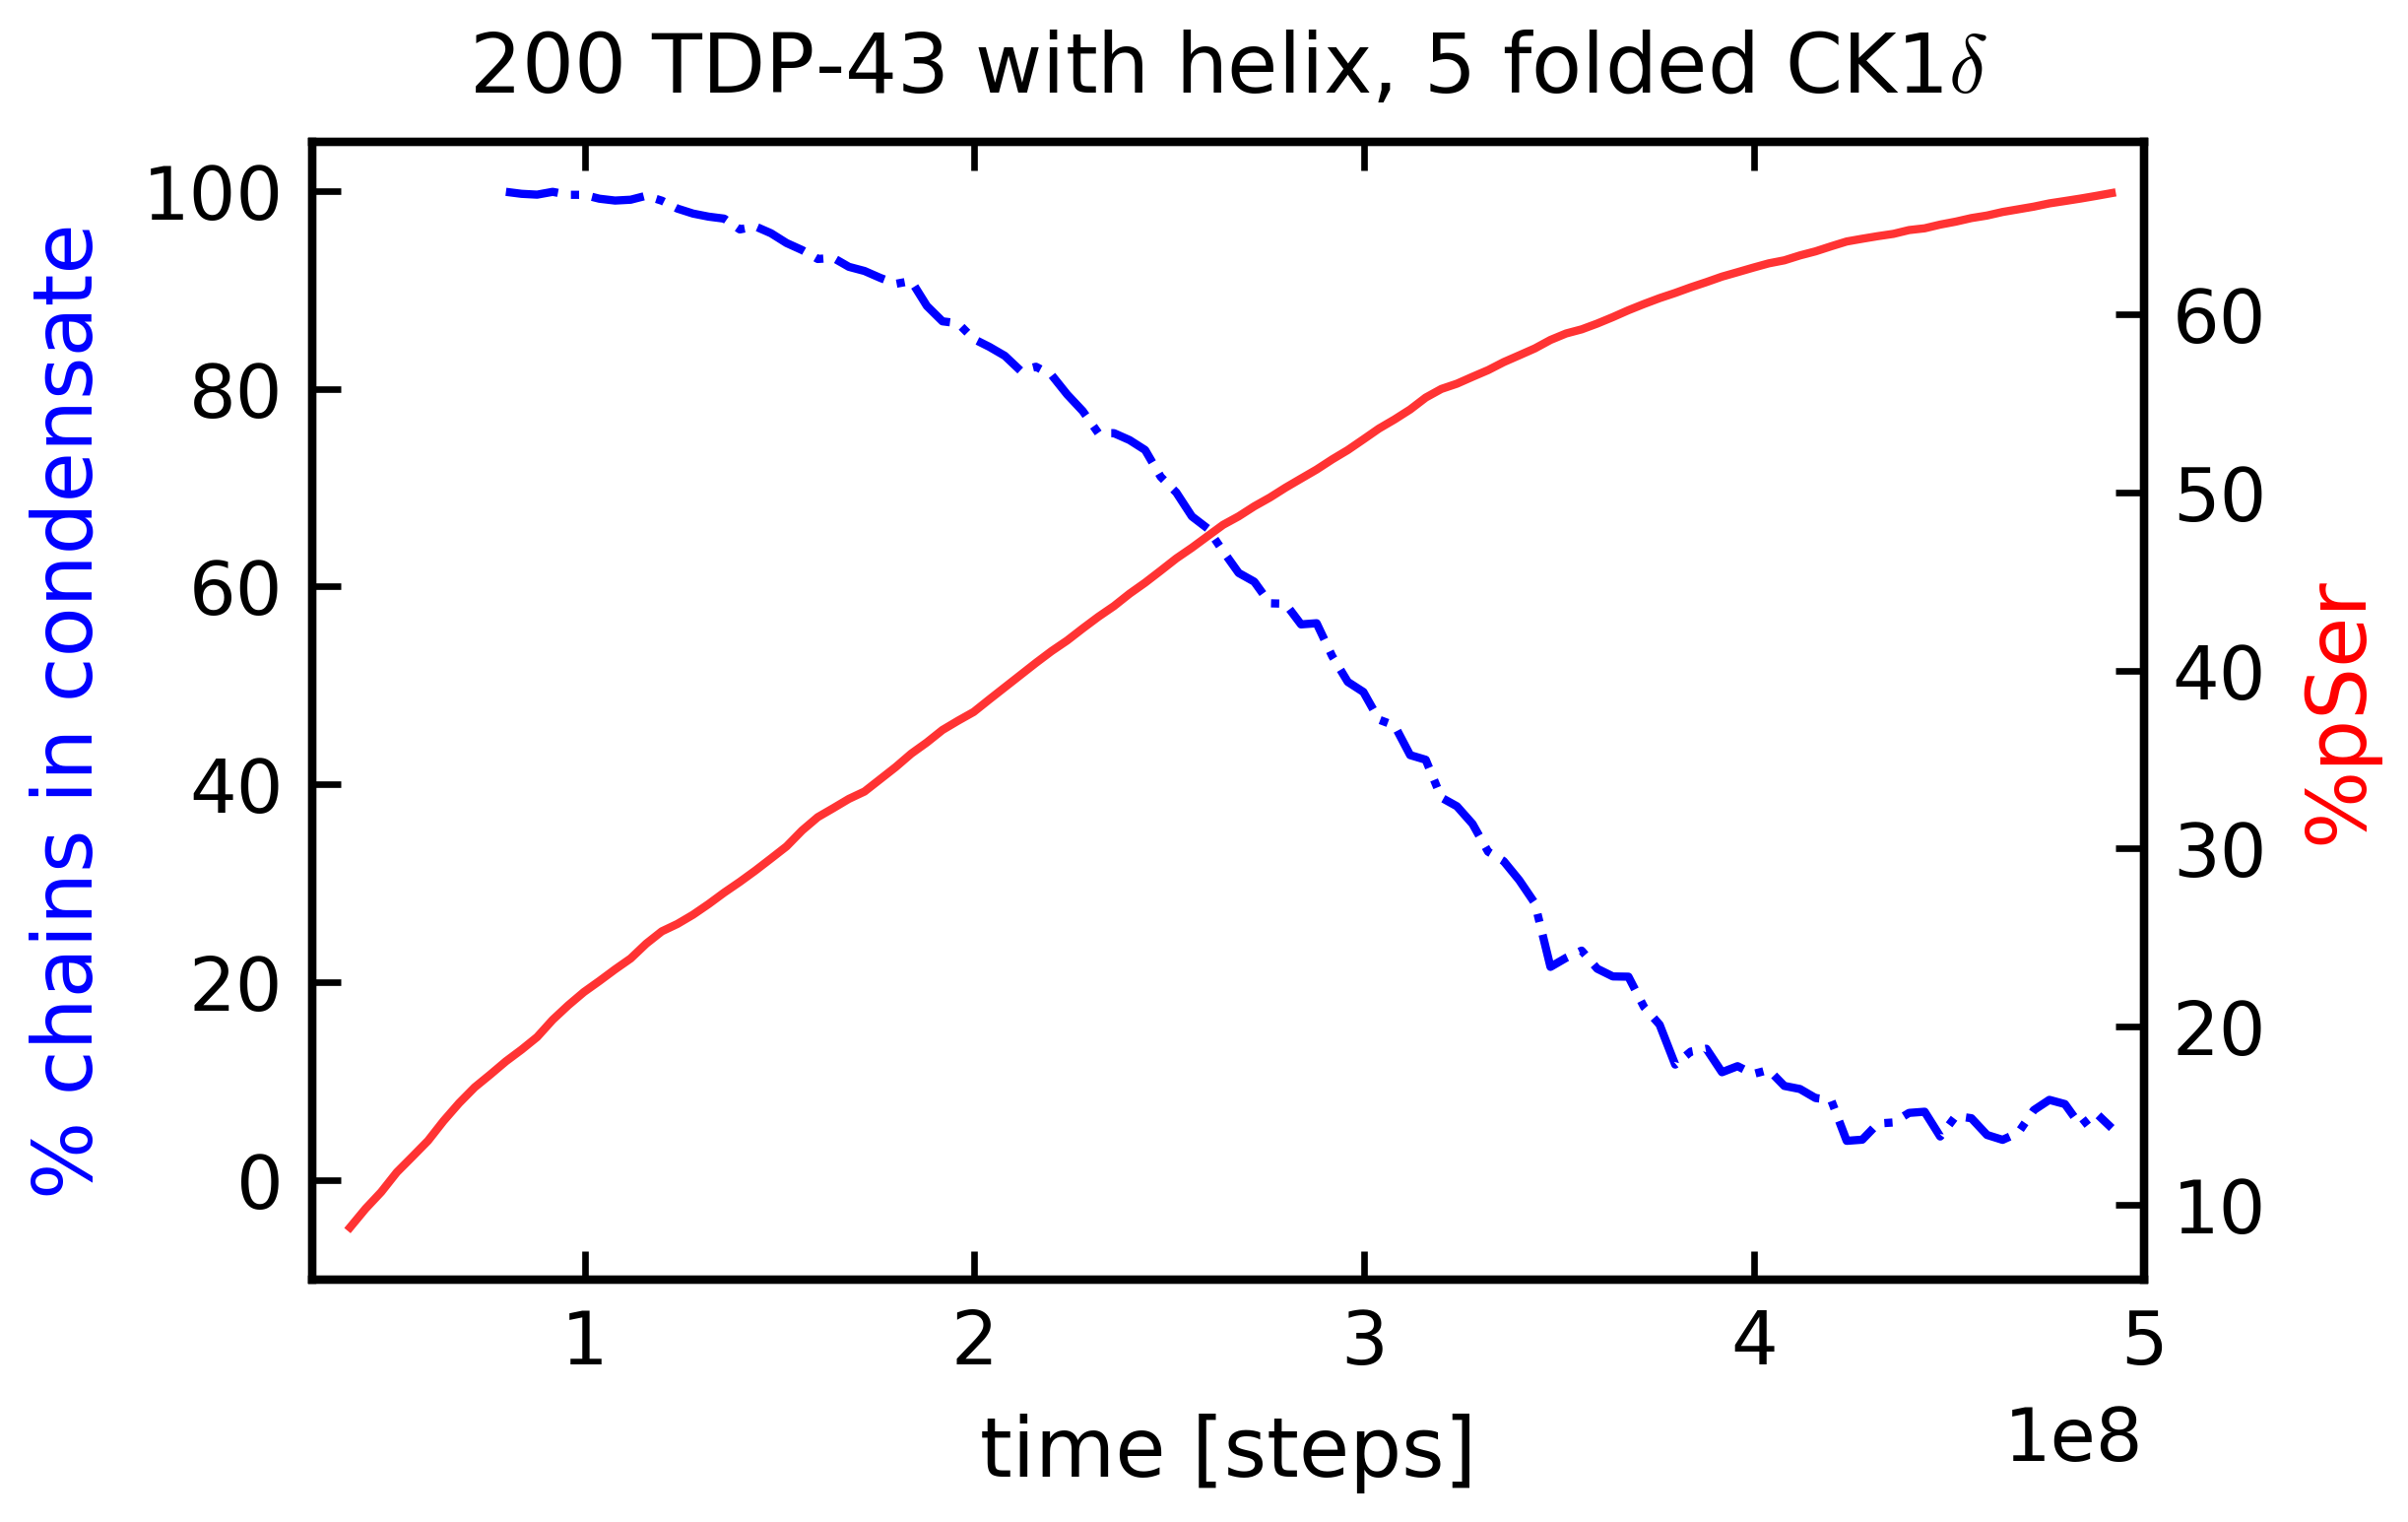

In [81]:
time_step = times*200000

fig, ax1 = plt.subplots(figsize=(4, 2.5))
plt.title("200 TDP-43 with helix, 5 folded CK1$\delta$", fontsize=10)

# Plot the first array with the primary y-axis
ax1.plot(time_step[10:-1], nc_5ck1d_helix[10:]/2, 'b-.')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% chains in condensate', color='b')
ax1.plot(time_step[0], nc_5ck1d_helix[0]/2, 'k-.', label=r'5 CK1$\delta$')

ax1.set_ylim((-10,105))

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step[:-1], np_5ck1d_helix/48,  'r', alpha=0.8)
ax2.set_ylabel('%pSer', color='r')
ax2.set_xlim((0.3*10**8,5.0*10**8))

## Enzymes in condensate

In [55]:
ne_1ck1d_np = np.zeros(len(times_np))
ne_3ck1d_np = np.zeros(len(times_np))
ne_5ck1d_np = np.zeros(len(times_np))
for i in [1,2,3,4]:
    tmp1 = enzymes_in_condensate(file+f'sim{i}_1-folded-ck1d_multi-tdp43_np_32b_dump_processed.gsd', times_np, n_enz=1, eps=1.0, min_sample=2)
    tmp3 = enzymes_in_condensate(file+f'sim{i}_3-folded-ck1d_multi-tdp43_np_32b_dump_processed.gsd', times_np, n_enz=3, eps=1.0, min_sample=2)
    tmp5 = enzymes_in_condensate(file+f'sim{i}_5-folded-ck1d_multi-tdp43_np_32b_dump_processed.gsd', times_np, n_enz=5, eps=1.0, min_sample=2)
    ne_1ck1d_np += tmp1
    ne_3ck1d_np += tmp3
    ne_5ck1d_np += tmp5
    
ne_1ck1d_np /=4
ne_3ck1d_np /=4
ne_5ck1d_np /=4

2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.36it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:54<00:00,  2.27it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:53<00:00,  2.30it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.34it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.34it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.34it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.33it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:53<00:00,  2.29it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:53<00:00,  2.32it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.35it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:52<00:00,  2.33it/s]


2450


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:53<00:00,  2.30it/s]


In [56]:
ne_1ck1d = np.zeros(len(times_sh))
ne_3ck1d = np.zeros(len(times_sh))
ne_5ck1d = np.zeros(len(times_sh))
for i in [1,2,3,4]:
    tmp1 = enzymes_in_condensate(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_sh, n_enz=1, eps=1.0, min_sample=2)
    tmp3 = enzymes_in_condensate(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_sh, n_enz=3, eps=1.0, min_sample=2)
    tmp5 = enzymes_in_condensate(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_sh, n_enz=5, eps=1.0, min_sample=2)
    ne_1ck1d += tmp1
    ne_3ck1d += tmp3
    ne_5ck1d += tmp5
    
ne_1ck1d /=4
ne_3ck1d /=4
ne_5ck1d /=4

ne_1ck1d_dis = np.zeros(len(times_dis))
ne_3ck1d_dis = np.zeros(len(times_dis))
ne_5ck1d_dis = np.zeros(len(times_dis))
for i in [1,2,3,4]:
    tmp1 = enzymes_in_condensate(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_dis, n_enz=1, eps=1.0, min_sample=2)
    tmp3 = enzymes_in_condensate(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_dis, n_enz=3, eps=1.0, min_sample=2)
    tmp5 = enzymes_in_condensate(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_dis, n_enz=5, eps=1.0, min_sample=2)
    ne_1ck1d_dis += tmp1
    ne_3ck1d_dis += tmp3
    ne_5ck1d_dis += tmp5
    
ne_1ck1d_dis /=4
ne_3ck1d_dis /=4
ne_5ck1d_dis /=4

2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.37it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.35it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.47it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.38it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.40it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.34it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.43it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.33it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.27it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.35it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.45it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.60it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.48it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.47it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.80it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.46it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.45it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.78it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.40it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.43it/s]


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.62it/s]


In [57]:
np_1ck1d_sh = np.zeros(len(times_sh))
np_3ck1d_sh = np.zeros(len(times_sh))
np_5ck1d_sh = np.zeros(len(times_sh))
for i in [1,2,3,4]:
    tmp1 = nphospho_in_time(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    tmp3 = nphospho_in_time(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    tmp5 = nphospho_in_time(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    np_1ck1d_sh += tmp1
    np_3ck1d_sh += tmp3
    np_5ck1d_sh += tmp5
    
np_1ck1d_sh /=4
np_3ck1d_sh /=4
np_5ck1d_sh /=4

np_1ck1d_dis = np.zeros(len(times_dis))
np_3ck1d_dis = np.zeros(len(times_dis))
np_5ck1d_dis = np.zeros(len(times_dis))
for i in [1,2,3,4]:
    tmp1_d = nphospho_in_time(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump.gsd', times_dis)
    tmp3_d = nphospho_in_time(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump.gsd', times_dis)
    tmp5_d = nphospho_in_time(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump.gsd', times_dis)
    np_1ck1d_dis += tmp1_d
    np_3ck1d_dis += tmp3_d
    np_5ck1d_dis += tmp5_d
    
np_1ck1d_dis /=4
np_3ck1d_dis /=4
np_5ck1d_dis /=4

2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500


In [58]:
np.savetxt(file+'enz_in_cond_1-folded-ck1d_multi-tdp43_sh.txt', ne_1ck1d)
np.savetxt(file+'enz_in_cond_3-folded-ck1d_multi-tdp43_sh.txt', ne_3ck1d)
np.savetxt(file+'enz_in_cond_5-folded-ck1d_multi-tdp43_sh.txt', ne_5ck1d)

np.savetxt(file+'enz_in_cond_1-folded-ck1d_multi-tdp43_np.txt', ne_1ck1d_np)
np.savetxt(file+'enz_in_cond_3-folded-ck1d_multi-tdp43_np.txt', ne_3ck1d_np)
np.savetxt(file+'enz_in_cond_5-folded-ck1d_multi-tdp43_np.txt', ne_5ck1d_np)

Text(0, 0.5, '% CK1$\\delta$ in condensate')

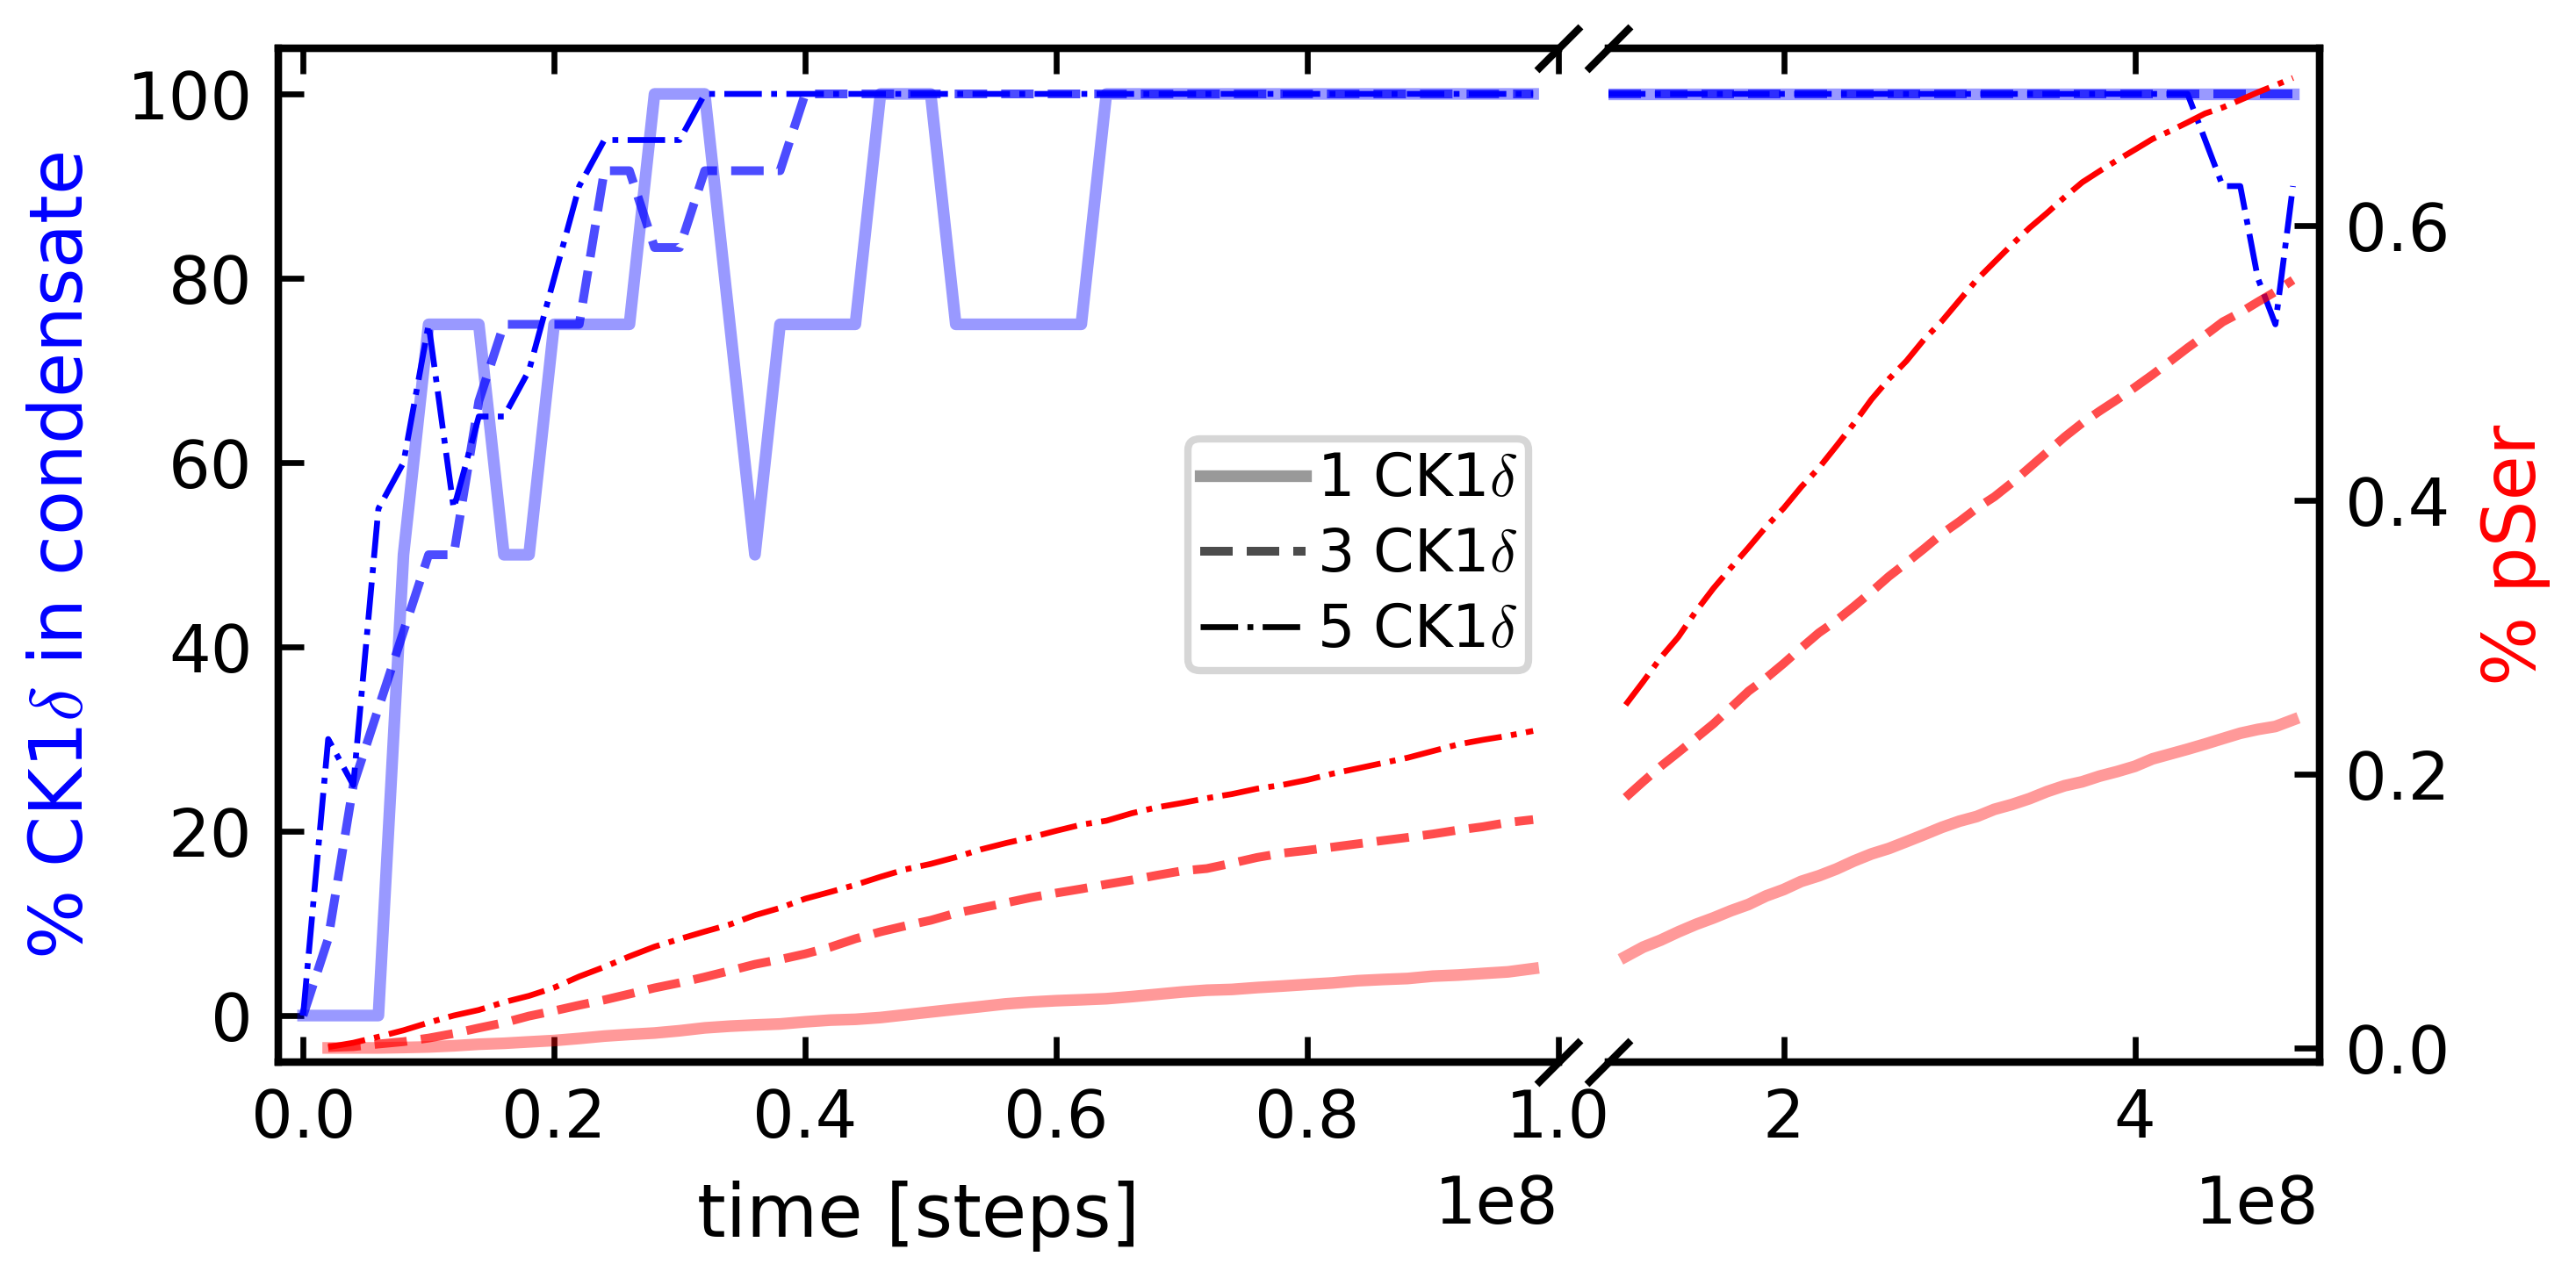

In [63]:
time_step_sh = times_sh*200000
time_step_dis = times_dis*200000

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5,2.5), gridspec_kw={'width_ratios': [1.8, 1]})
fig.subplots_adjust(wspace=0.05)

ax1.plot(time_step_sh, ne_1ck1d*100, 'b', lw=1.6, alpha=0.4)
ax1.plot(time_step_sh, ne_3ck1d/3*100, 'b--', lw=1.2, alpha=0.7)
ax1.plot(time_step_sh, ne_5ck1d/5*100, 'b-.', lw=0.8, alpha=1)
ax1.set_xlim(-0.02*10**8,1*10**8)

ax11 = ax1.twinx()
ax11.plot(time_step_sh[1:], np_1ck1d_sh[1:] /4800,  'r', lw=1.6, alpha=0.4)
ax11.plot(time_step_sh[1:], np_3ck1d_sh[1:] /4800, 'r--', lw=1.2, alpha=0.7)
ax11.plot(time_step_sh[1:], np_5ck1d_sh[1:] /4800, 'r-.', lw=0.8, alpha=1)
ax11.set_ylim(-0.01,0.73)

ax2.plot(time_step_dis, ne_1ck1d_dis*100, 'b', lw=1.6, alpha=0.4)
ax2.plot(time_step_dis, ne_3ck1d_dis/3*100, 'b--', lw=1.2, alpha=0.7)
ax2.plot(time_step_dis, ne_5ck1d_dis/5*100, 'b-.', lw=0.8, alpha=1)
ax2.set_xlim(1.0*10**8,5.05*10**8)

ax22 = ax2.twinx()
ax22.plot(time_step_dis[1:], np_1ck1d_dis[1:] /4800, 'r', lw=1.6, alpha=0.4)
ax22.plot(time_step_dis[1:], np_3ck1d_dis[1:] /4800, 'r--', lw=1.2, alpha=0.7)
ax22.plot(time_step_dis[1:], np_5ck1d_dis[1:] /4800, 'r-.', lw=0.8, alpha=1)
ax22.set_ylabel('% pSer', color='r')
ax22.set_ylim(-0.01,0.73)

ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k', label=r'1 CK1$\delta$', lw=1.6, alpha=0.4)
ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k--', label=r'3 CK1$\delta$',  lw=1.2, alpha=0.7)
ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k-.', label=r'5 CK1$\delta$', lw=0.8, alpha=1)
ax1.legend(ncols=1, loc='center right')

# hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax11.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax22.spines.left.set_visible(False)
ax1.tick_params(right=False)  # don't put tick labels at the top
ax11.tick_params(right=False, labelright=False)  # don't put tick labels at the top
ax2.tick_params(right=False, left=False, labelleft=False)  # don't put tick labels at the top

d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=6,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1,1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0,0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% CK1$\delta$ in condensate', color='b')

(0.0, 509999999.99999994)

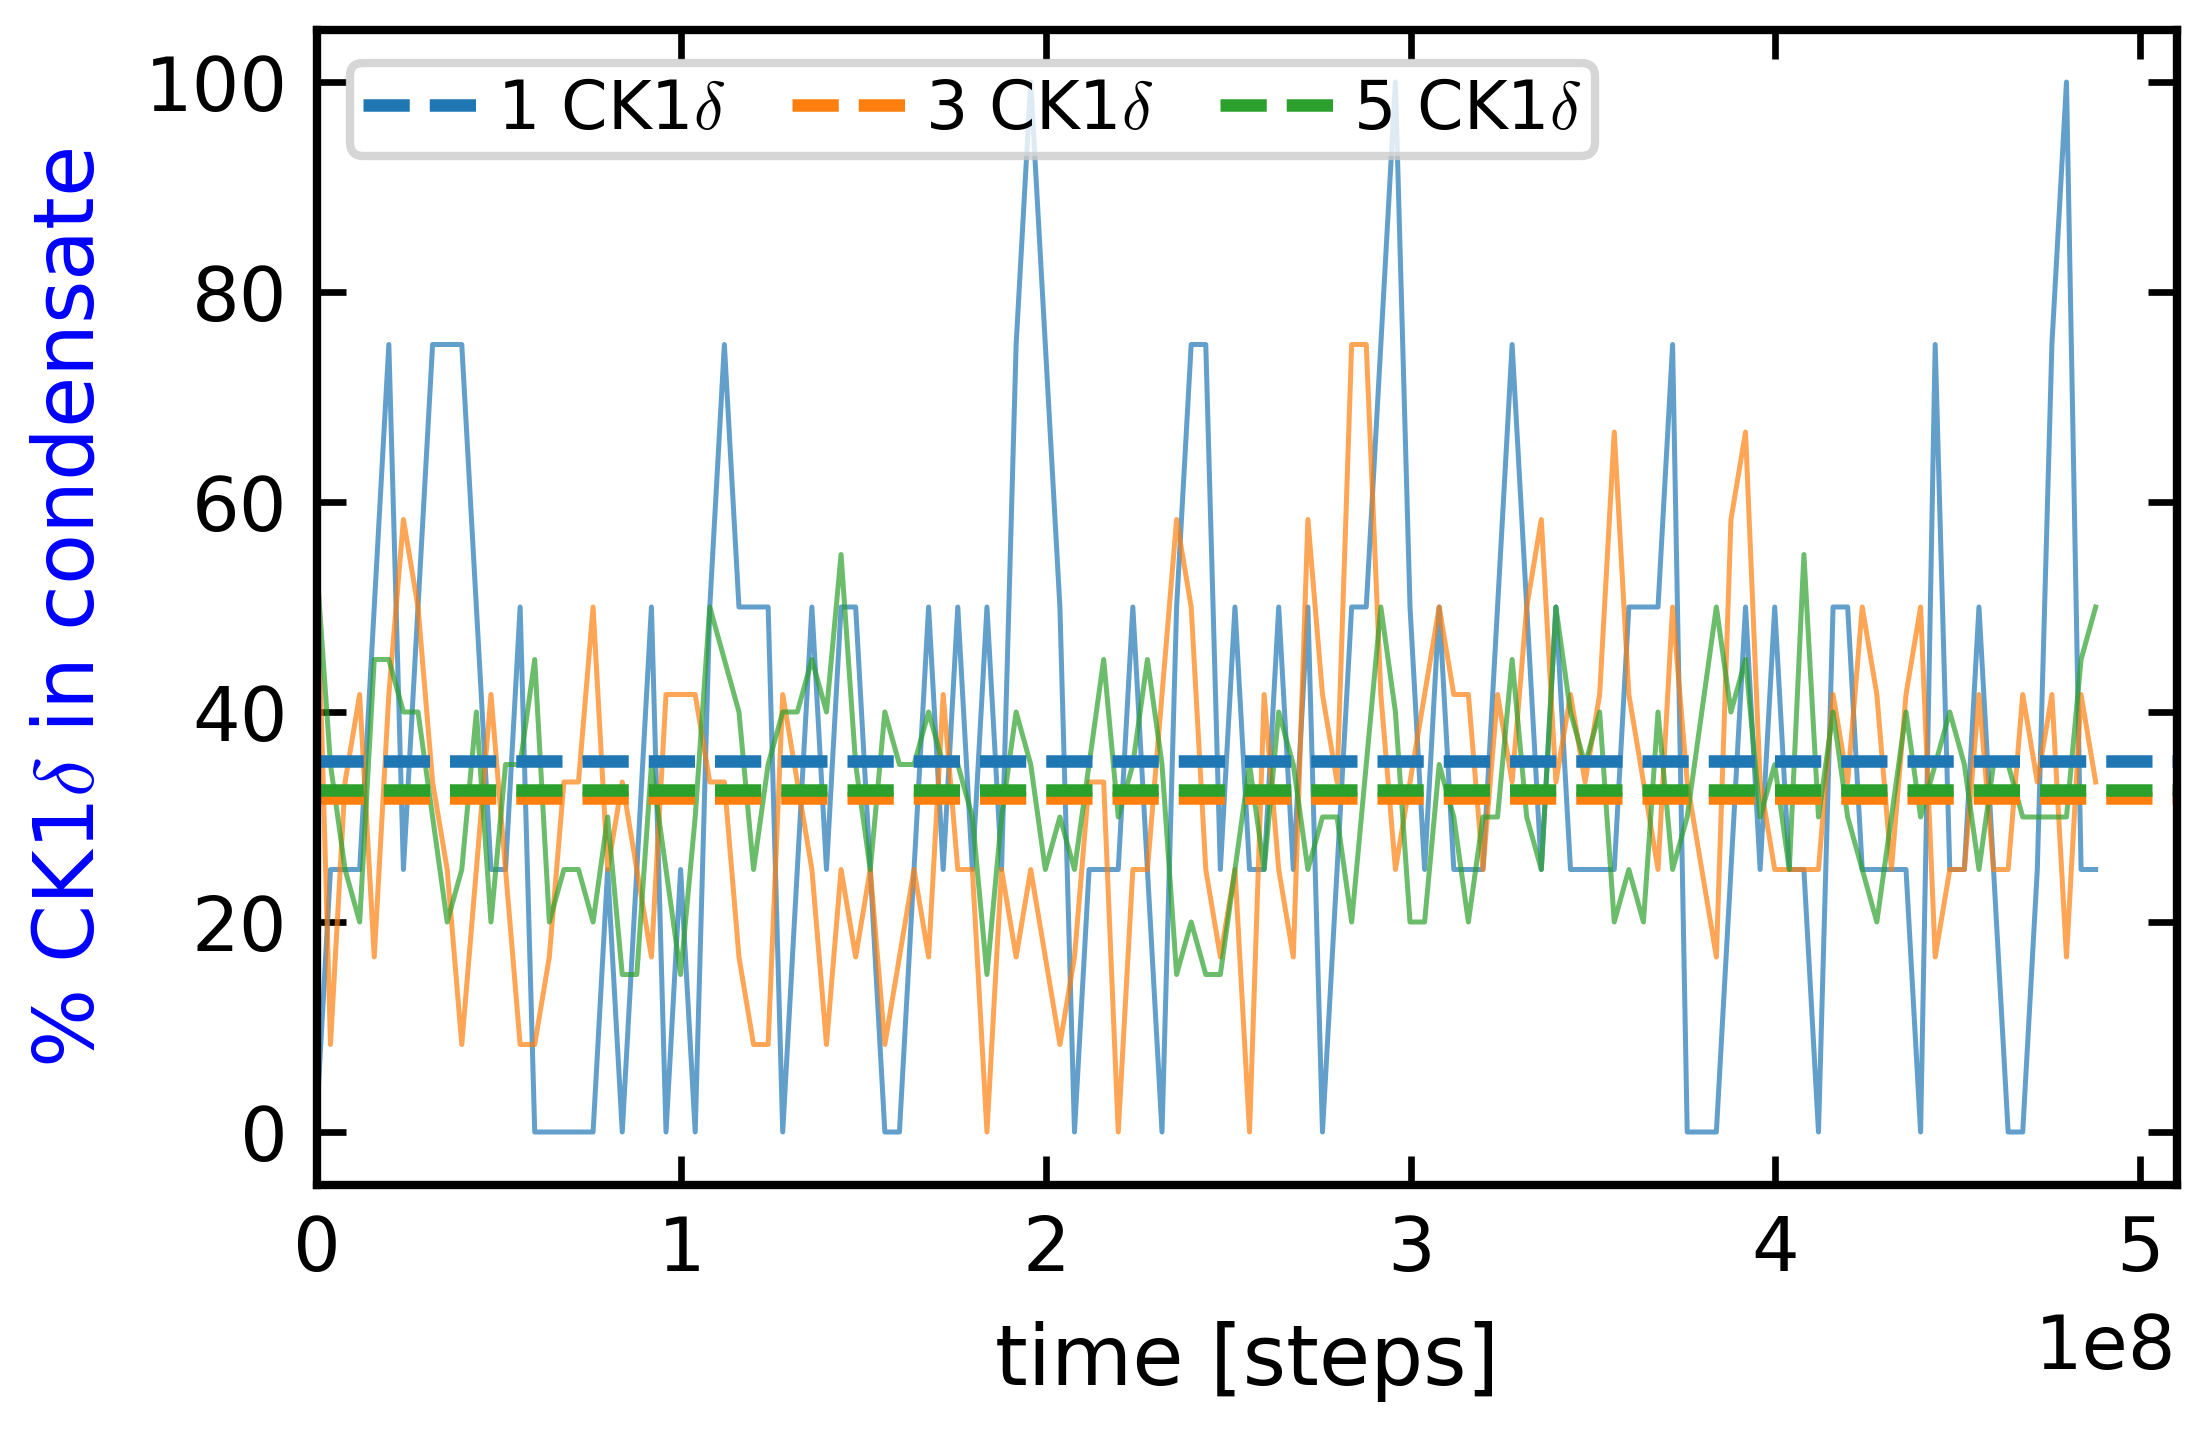

In [64]:
time_step_np = times_np*200000

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step_np, ne_1ck1d_np*100, 'tab:blue', alpha=0.7, lw=0.6)
ax1.plot(time_step_np, ne_3ck1d_np/3*100, 'tab:orange', alpha=0.7, lw=0.6)
ax1.plot(time_step_np, ne_5ck1d_np/5*100, 'tab:green', alpha=0.7, lw=0.6)
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% CK1$\delta$ in condensate', color='b')
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_1ck1d_np)*100]*2, '--', color='tab:blue', label=r'1 CK1$\delta$', lw=1.5)
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_3ck1d_np)/3*100]*2, '--', color='tab:orange', label=r'3 CK1$\delta$', lw=1.5)
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_5ck1d_np)/5*100]*2, '--', color='tab:green', label=r'5 CK1$\delta$', lw=1.5)

ax1.legend(ncols=3, loc='upper left')
ax1.set_xlim((0*10**8,5.1*10**8))


## Condensate density profiles

In [65]:
file_40pcent = ''
bin_edges = np.linspace(0,30,55)

counts_ser_40pcent = np.zeros(len(bin_edges)-1)
counts_pser_40pcent = np.zeros(len(bin_edges)-1)
counts_enz_40pcent = np.zeros(len(bin_edges)-1)

# bin counts normalized by volume of the bin
for i in [1,2,3,4]:
    tmp_counts_ser_40pcent, tmp_counts_pser_40pcent = radial_distribution_pSer(file_40pcent+f'sim{i}_5-folded-ck1d_multi-tdp43_40pcent_pSer_rep1_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=False)
    counts_ser_40pcent += tmp_counts_ser_40pcent
    counts_pser_40pcent += tmp_counts_pser_40pcent
    tmp_counts_enz_40pcent = radial_distribution_enzyme(file_40pcent+f'sim{i}_5-folded-ck1d_multi-tdp43_40pcent_pSer_rep1_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=False)
    counts_enz_40pcent += tmp_counts_enz_40pcent
    
    
counts_ser_40pcent /=4
counts_pser_40pcent /=4
counts_enz_40pcent /=4

500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.87it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:17,  2.82it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.82it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.82it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.84it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.84it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.83it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.84it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.85it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.85it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.85it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.86it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:12,  2.87it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.86it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.87it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.86it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.88it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.87it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.88it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.88it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.85it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.85it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.85it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.85it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.83it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.83it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.84it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.83it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.83it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.82it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.82it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.83it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.84it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.85it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.86it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.86it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:12<00:04,  2.88it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.87it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.87it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.86it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.85it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.85it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.84it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.84it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.84it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.85it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.85it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.85it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.85it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]

5.0


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.84it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:17,  2.82it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.81it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.81it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:16,  2.81it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.81it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.82it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.81it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.82it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.82it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.82it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.83it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:13,  2.83it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.83it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.85it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.85it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:11,  2.85it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.86it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.86it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.86it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.87it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.86it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.86it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.85it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.85it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.84it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.82it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.82it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.83it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.83it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.82it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.83it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.83it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.84it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.85it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.84it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:13<00:04,  2.84it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.85it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.85it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.86it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.86it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.85it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.85it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.87it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.86it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.85it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.84it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.85it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.84it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]

5.0


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.85it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:16,  2.86it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.86it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.86it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.87it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.86it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:14,  2.87it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.86it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.86it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:13,  2.87it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.88it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.88it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:12,  2.86it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.86it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.85it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.86it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.86it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.86it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.86it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:06<00:10,  2.86it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.86it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.87it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.87it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.88it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.87it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.88it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.87it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.86it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.85it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.85it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.86it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.86it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.86it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.87it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.87it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.87it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:12<00:04,  2.88it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.87it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.87it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:13<00:03,  2.86it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.85it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.86it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.86it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.87it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.87it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.87it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.85it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.86it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.86it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]

5.0


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.06it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:16,  2.89it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:16,  2.89it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.89it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.87it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.87it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.86it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:14,  2.87it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.87it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.86it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.86it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.85it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.85it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:12,  2.85it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.85it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.86it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.86it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.85it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.86it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.86it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:06<00:10,  2.86it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.87it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.87it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.87it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.86it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.86it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.85it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.85it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.85it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.84it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.84it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.85it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.84it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.84it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.84it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.84it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.85it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:12<00:04,  2.85it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.85it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.86it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.86it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.85it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.85it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.85it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.85it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.85it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.85it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.85it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.86it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.85it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]

5.0


In [66]:
bin_edges = np.linspace(0,30,55)

counts_ser_40pcent_part = np.zeros(len(bin_edges)-1)
counts_pser_40pcent_part = np.zeros(len(bin_edges)-1)
counts_enz_40pcent_part = np.zeros(len(bin_edges)-1)

# bin counts normalized by number of particles in the bin
for i in [1,2,3,4]:
    tmp_counts_ser_40pcent, tmp_counts_pser_40pcent = radial_distribution_pSer(file_40pcent+f'sim{i}_5-folded-ck1d_multi-tdp43_40pcent_pSer_rep1_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=True)
    counts_ser_40pcent_part += tmp_counts_ser_40pcent
    counts_pser_40pcent_part += tmp_counts_pser_40pcent
    tmp_counts_enz_40pcent = radial_distribution_enzyme(file_40pcent+f'sim{i}_5-folded-ck1d_multi-tdp43_40pcent_pSer_rep1_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=True)
    counts_enz_40pcent_part += tmp_counts_enz_40pcent
    
    
counts_ser_40pcent_part /=4
counts_pser_40pcent_part /=4
counts_enz_40pcent_part /=4

500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.87it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:16,  2.85it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.83it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.83it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.84it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.83it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.82it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.84it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.83it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.83it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.83it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.85it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:12,  2.85it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.85it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.85it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.85it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.86it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.86it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.86it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.86it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.84it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.84it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.84it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.84it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.82it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.82it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.83it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.82it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.82it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.81it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.79it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.80it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:06,  2.81it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:12<00:05,  2.82it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.83it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.84it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:13<00:04,  2.86it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.85it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.85it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.85it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.84it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.82it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.82it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.82it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.82it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.83it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.83it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.84it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.83it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]

5.0


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.82it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:17,  2.82it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.81it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.81it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:16,  2.81it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.81it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.81it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:15,  2.80it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.81it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.81it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.81it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.82it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:13,  2.83it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.82it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.83it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.83it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:11,  2.84it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.84it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.84it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.84it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.85it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.84it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.84it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.83it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.83it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.82it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.81it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.80it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.80it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.81it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.80it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.81it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:06,  2.81it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:12<00:05,  2.82it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.83it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.83it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:13<00:04,  2.83it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.84it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.84it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.85it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.84it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.84it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.84it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.85it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.85it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.84it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.84it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.84it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.83it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]

5.0


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.75it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.85it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:16,  2.85it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.85it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.84it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.85it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.85it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.85it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.84it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.84it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.84it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.86it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.86it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:12,  2.85it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.85it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.84it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.84it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.84it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.84it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.84it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.84it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.85it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.86it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.85it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.86it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.86it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.86it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.85it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.84it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.84it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.84it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.84it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.84it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.84it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.85it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.85it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.85it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:12<00:04,  2.86it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.85it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.85it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.84it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.83it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.84it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.85it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.85it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.86it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.85it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.83it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.84it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.84it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


5.0
500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]


500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:17,  2.87it/s]

5.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:16,  2.88it/s]

5.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:16,  2.88it/s]

5.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:16,  2.86it/s]

5.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:15,  2.85it/s]

5.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:15,  2.85it/s]

5.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:15,  2.86it/s]

5.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:02<00:14,  2.86it/s]

5.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:14,  2.84it/s]

5.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:14,  2.84it/s]

5.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:03<00:13,  2.84it/s]

5.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:13,  2.84it/s]

5.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:13,  2.84it/s]

5.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:04<00:12,  2.84it/s]

5.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:12,  2.85it/s]

5.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:05<00:11,  2.85it/s]

5.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:05<00:11,  2.84it/s]

5.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:11,  2.84it/s]

5.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:06<00:10,  2.85it/s]

5.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:10,  2.85it/s]

5.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:07<00:10,  2.85it/s]

5.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:07<00:09,  2.85it/s]

5.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:09,  2.85it/s]

5.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:08<00:09,  2.85it/s]

5.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:08<00:08,  2.84it/s]

5.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:08,  2.84it/s]

5.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:09<00:08,  2.82it/s]

5.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:09<00:07,  2.83it/s]

5.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:10<00:07,  2.83it/s]

5.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:10<00:07,  2.83it/s]

5.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:10<00:06,  2.85it/s]

5.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:11<00:06,  2.83it/s]

5.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:11<00:05,  2.83it/s]

5.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:11<00:05,  2.83it/s]

5.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:12<00:05,  2.83it/s]

5.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:12<00:04,  2.84it/s]

5.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:13<00:04,  2.84it/s]

5.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:13<00:04,  2.84it/s]

5.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:13<00:03,  2.84it/s]

5.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:14<00:03,  2.84it/s]

5.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:14<00:03,  2.84it/s]

5.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:14<00:02,  2.84it/s]

5.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:15<00:02,  2.85it/s]

5.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:15<00:02,  2.84it/s]

5.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:15<00:01,  2.84it/s]

5.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:16<00:01,  2.84it/s]

5.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:16<00:01,  2.84it/s]

5.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:16<00:00,  2.85it/s]

5.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:17<00:00,  2.85it/s]

5.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.84it/s]

5.0


In [78]:
bin_edges = np.linspace(0,30,55)

counts_ser_eq_part = np.zeros(len(bin_edges)-1)
counts_pser_eq_part = np.zeros(len(bin_edges)-1)
counts_enz_eq_part = np.zeros(len(bin_edges)-1)

for i in [1,2,3,4]:
    tmp_counts_ser_eq, tmp_counts_pser_eq = radial_distribution_pSer(f'sim{i}_5-folded-ck1d_multi-tdp43_np_32b_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=True)
    counts_ser_eq_part += tmp_counts_ser_eq
    counts_pser_eq_part += tmp_counts_pser_eq
    tmp_counts_enz_eq = radial_distribution_enzyme(f'sim{i}_5-folded-ck1d_multi-tdp43_np_32b_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=True)
    counts_enz_eq_part += tmp_counts_enz_eq
    
    
counts_ser_eq_part /=4
counts_pser_eq_part /=4
counts_enz_eq_part /=4

2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.68it/s]


2500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:19,  2.55it/s]

0.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:18,  2.58it/s]

1.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:18,  2.59it/s]

2.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:17,  2.60it/s]

2.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:17,  2.59it/s]

2.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:17,  2.59it/s]

3.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:16,  2.59it/s]

3.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:03<00:16,  2.60it/s]

3.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:15,  2.60it/s]

3.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:15,  2.58it/s]

2.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:04<00:15,  2.59it/s]

2.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:14,  2.58it/s]

2.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:05<00:14,  2.59it/s]

3.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:05<00:13,  2.61it/s]

3.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:13,  2.61it/s]

1.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:06<00:12,  2.62it/s]

3.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:12,  2.61it/s]

3.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:12,  2.62it/s]

1.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:07<00:11,  2.62it/s]

2.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:11,  2.62it/s]

1.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:08<00:11,  2.63it/s]

1.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:08<00:10,  2.63it/s]

1.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:10,  2.62it/s]

2.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:09<00:09,  2.63it/s]

2.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:09<00:09,  2.62it/s]

1.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:09,  2.63it/s]

1.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:10<00:08,  2.62it/s]

1.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:10<00:08,  2.60it/s]

1.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:11<00:08,  2.60it/s]

1.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:11<00:07,  2.59it/s]

0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:11<00:07,  2.59it/s]

1.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:12<00:06,  2.61it/s]

3.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:12<00:06,  2.60it/s]

1.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:13<00:06,  2.59it/s]

1.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:13<00:05,  2.60it/s]

1.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:13<00:05,  2.61it/s]

0.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:14<00:04,  2.62it/s]

1.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:14<00:04,  2.63it/s]

0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:14<00:04,  2.63it/s]

1.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:15<00:03,  2.64it/s]

1.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:15<00:03,  2.62it/s]

1.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:16<00:03,  2.62it/s]

0.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:16<00:02,  2.61it/s]

0.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:16<00:02,  2.62it/s]

0.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:17<00:01,  2.63it/s]

1.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:17<00:01,  2.62it/s]

1.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:18<00:01,  2.60it/s]

3.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:18<00:00,  2.55it/s]

2.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:18<00:00,  2.56it/s]

1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]

1.0


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


2500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:19,  2.57it/s]

0.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:18,  2.60it/s]

1.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:18,  2.54it/s]

1.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:18,  2.50it/s]

2.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:17,  2.50it/s]

1.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:17,  2.51it/s]

2.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:17,  2.52it/s]

2.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:03<00:16,  2.56it/s]

2.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:15,  2.57it/s]

3.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:16,  2.48it/s]

2.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:04<00:16,  2.44it/s]

2.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:15,  2.50it/s]

1.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:05<00:14,  2.55it/s]

1.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:05<00:13,  2.57it/s]

1.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:13,  2.60it/s]

0.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:06<00:12,  2.62it/s]

2.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:12,  2.62it/s]

1.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:07<00:12,  2.64it/s]

1.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:07<00:11,  2.63it/s]

3.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:11,  2.62it/s]

2.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:08<00:11,  2.61it/s]

2.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:08<00:10,  2.62it/s]

2.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:10,  2.64it/s]

1.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:09<00:09,  2.64it/s]

1.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:09<00:09,  2.63it/s]

1.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:10<00:09,  2.64it/s]

1.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:10<00:08,  2.64it/s]

1.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:10<00:08,  2.62it/s]

3.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:11<00:07,  2.63it/s]

1.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:11<00:07,  2.63it/s]

1.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:11<00:07,  2.62it/s]

3.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:12<00:06,  2.60it/s]

2.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:12<00:06,  2.61it/s]

2.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:13<00:06,  2.60it/s]

1.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:13<00:05,  2.61it/s]

0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:13<00:05,  2.63it/s]

2.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:14<00:04,  2.62it/s]

1.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:14<00:04,  2.63it/s]

1.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:15<00:04,  2.63it/s]

1.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:15<00:03,  2.62it/s]

1.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:15<00:03,  2.61it/s]

3.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:16<00:03,  2.61it/s]

3.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:16<00:02,  2.62it/s]

3.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:16<00:02,  2.63it/s]

2.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:17<00:01,  2.63it/s]

1.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:17<00:01,  2.63it/s]

1.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:18<00:01,  2.64it/s]

0.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:18<00:00,  2.65it/s]

0.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:18<00:00,  2.63it/s]

0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]

0.0


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


2500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:19,  2.51it/s]

0.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:19,  2.52it/s]

0.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:18,  2.58it/s]

0.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:17,  2.60it/s]

2.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:01<00:17,  2.58it/s]

2.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:16,  2.60it/s]

0.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:16,  2.61it/s]

1.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:03<00:15,  2.63it/s]

1.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:15,  2.64it/s]

1.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:15,  2.64it/s]

1.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:04<00:14,  2.63it/s]

1.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:14,  2.62it/s]

1.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:04<00:14,  2.61it/s]

2.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:05<00:13,  2.60it/s]

3.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:13,  2.60it/s]

2.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:06<00:13,  2.59it/s]

1.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:12,  2.58it/s]

1.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:06<00:12,  2.59it/s]

3.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:07<00:12,  2.58it/s]

4.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:11,  2.58it/s]

2.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:08<00:11,  2.60it/s]

3.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:08<00:10,  2.61it/s]

2.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:10,  2.60it/s]

2.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:09<00:09,  2.61it/s]

0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:09<00:09,  2.62it/s]

0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:09<00:09,  2.63it/s]

1.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:10<00:08,  2.63it/s]

1.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:10<00:08,  2.62it/s]

3.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:11<00:07,  2.63it/s]

4.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:11<00:07,  2.62it/s]

4.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:11<00:07,  2.62it/s]

3.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:12<00:06,  2.63it/s]

1.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:12<00:06,  2.63it/s]

2.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:13<00:06,  2.62it/s]

3.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:13<00:05,  2.63it/s]

3.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:13<00:05,  2.62it/s]

3.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:14<00:04,  2.63it/s]

2.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:14<00:04,  2.63it/s]

1.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:14<00:04,  2.63it/s]

2.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:15<00:03,  2.64it/s]

2.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:15<00:03,  2.62it/s]

2.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:16<00:03,  2.57it/s]

1.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:16<00:02,  2.55it/s]

1.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:16<00:02,  2.54it/s]

1.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:17<00:01,  2.54it/s]

2.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:17<00:01,  2.52it/s]

3.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:18<00:01,  2.55it/s]

1.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:18<00:00,  2.55it/s]

1.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:18<00:00,  2.46it/s]

2.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]

2.0


2500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


2500


  2%|███▌                                                                                                                                                                           | 1/50 [00:00<00:20,  2.42it/s]

0.0


  4%|███████                                                                                                                                                                        | 2/50 [00:00<00:18,  2.54it/s]

3.0


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:01<00:18,  2.57it/s]

3.0


  8%|██████████████                                                                                                                                                                 | 4/50 [00:01<00:18,  2.50it/s]

3.0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [00:02<00:18,  2.42it/s]

0.0


 12%|█████████████████████                                                                                                                                                          | 6/50 [00:02<00:18,  2.42it/s]

1.0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [00:02<00:17,  2.48it/s]

0.0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [00:03<00:16,  2.52it/s]

1.0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [00:03<00:16,  2.56it/s]

1.0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [00:03<00:15,  2.58it/s]

0.0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [00:04<00:15,  2.59it/s]

1.0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [00:04<00:14,  2.61it/s]

0.0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [00:05<00:14,  2.62it/s]

1.0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [00:05<00:13,  2.62it/s]

3.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [00:05<00:13,  2.62it/s]

2.0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [00:06<00:13,  2.61it/s]

2.0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [00:06<00:12,  2.62it/s]

2.0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [00:07<00:12,  2.61it/s]

2.0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [00:07<00:11,  2.60it/s]

1.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [00:07<00:11,  2.60it/s]

2.0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [00:08<00:11,  2.60it/s]

1.0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [00:08<00:10,  2.60it/s]

1.0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [00:08<00:10,  2.61it/s]

2.0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [00:09<00:10,  2.58it/s]

2.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [00:09<00:09,  2.58it/s]

3.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [00:10<00:09,  2.59it/s]

2.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [00:10<00:08,  2.60it/s]

1.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [00:10<00:08,  2.61it/s]

1.0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [00:11<00:08,  2.62it/s]

1.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [00:11<00:07,  2.62it/s]

1.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [00:12<00:07,  2.63it/s]

1.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [00:12<00:06,  2.63it/s]

1.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [00:12<00:06,  2.63it/s]

2.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [00:13<00:06,  2.63it/s]

2.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [00:13<00:05,  2.63it/s]

1.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [00:13<00:05,  2.63it/s]

2.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [00:14<00:04,  2.63it/s]

1.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [00:14<00:04,  2.63it/s]

1.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [00:15<00:04,  2.62it/s]

1.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [00:15<00:03,  2.63it/s]

1.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [00:15<00:03,  2.63it/s]

1.0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [00:16<00:03,  2.63it/s]

1.0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [00:16<00:02,  2.63it/s]

0.0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [00:16<00:02,  2.65it/s]

0.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [00:17<00:01,  2.64it/s]

1.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [00:17<00:01,  2.64it/s]

1.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [00:18<00:01,  2.60it/s]

2.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [00:18<00:00,  2.60it/s]

1.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [00:18<00:00,  2.61it/s]

2.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]

2.0


In [67]:
file_40pcent_f = ''

bin_edges = np.linspace(0,30,55)

counts_ser_eq_f = np.zeros(len(bin_edges)-1)
counts_pser_eq_f = np.zeros(len(bin_edges)-1)
counts_enz_eq_f = np.zeros(len(bin_edges)-1)
counts_tail_eq_f = np.zeros(len(bin_edges)-1)

for i in [1,2,3,4,5]:
    tmp_counts_ser_eq, tmp_counts_pser_eq = radial_distribution_pSer(file_40pcent_f+f'sim{i}_5-full-ck1d-open_200-tdp43_40pcent_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=False)
    counts_ser_eq_f += tmp_counts_ser_eq
    counts_pser_eq_f += tmp_counts_pser_eq
    tmp_counts_enz_full, tmp_counts_tail_full = radial_distribution_full_enzyme(file_40pcent_f+f'sim{i}_5-full-ck1d-open_200-tdp43_40pcent_dump_centered.gsd', times_sh, bin_edges, nenz=5, norm_particles=False)
    counts_enz_eq_f += tmp_counts_enz_full
    counts_tail_eq_f += tmp_counts_tail_full
    
    
counts_ser_eq_f /=5
counts_pser_eq_f /=5
counts_enz_eq_f /=5
counts_tail_eq_f /=5

500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.81it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.80it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.85it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.81it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.90it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.81it/s]


In [69]:
file_ck1d_in = ''
step = 5
times_fin = np.arange(100,500,step, dtype=int)
bin_edges = np.linspace(0,25,50)

counts_ser_in = np.zeros(len(bin_edges)-1)
counts_pser_in = np.zeros(len(bin_edges)-1)
counts_enz_in = np.zeros(len(bin_edges)-1)

tmp_counts_ser_in, tmp_counts_pser_in = radial_distribution_pSer(file_ck1d_in+f'sim1_1-folded-ck1d_multi-tdp43_inside_dump_centered.gsd', times_fin, bin_edges, nenz=1, norm_particles=False)
tmp_counts_enz_in = radial_distribution_enzyme(file_ck1d_in+f'sim1_1-folded-ck1d_multi-tdp43_inside_dump_centered.gsd', times_fin, bin_edges, nenz=1, norm_particles=False)
counts_ser_in += tmp_counts_ser_in
counts_enz_in += tmp_counts_enz_in 

500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:45<00:00,  1.75it/s]


500


  1%|██▏                                                                                                                                                                            | 1/80 [00:00<00:29,  2.69it/s]

1.0


  2%|████▍                                                                                                                                                                          | 2/80 [00:00<00:29,  2.67it/s]

1.0


  4%|██████▌                                                                                                                                                                        | 3/80 [00:01<00:28,  2.69it/s]

1.0


  5%|████████▊                                                                                                                                                                      | 4/80 [00:01<00:28,  2.71it/s]

1.0


  6%|██████████▉                                                                                                                                                                    | 5/80 [00:01<00:27,  2.71it/s]

1.0


  8%|█████████████▏                                                                                                                                                                 | 6/80 [00:02<00:27,  2.69it/s]

1.0


  9%|███████████████▎                                                                                                                                                               | 7/80 [00:02<00:27,  2.68it/s]

1.0


 10%|█████████████████▌                                                                                                                                                             | 8/80 [00:02<00:26,  2.67it/s]

1.0


 11%|███████████████████▋                                                                                                                                                           | 9/80 [00:03<00:26,  2.65it/s]

1.0


 12%|█████████████████████▊                                                                                                                                                        | 10/80 [00:03<00:26,  2.66it/s]

1.0


 14%|███████████████████████▉                                                                                                                                                      | 11/80 [00:04<00:25,  2.67it/s]

1.0


 15%|██████████████████████████                                                                                                                                                    | 12/80 [00:04<00:25,  2.68it/s]

1.0


 16%|████████████████████████████▎                                                                                                                                                 | 13/80 [00:04<00:24,  2.69it/s]

1.0


 18%|██████████████████████████████▍                                                                                                                                               | 14/80 [00:05<00:24,  2.70it/s]

1.0


 19%|████████████████████████████████▋                                                                                                                                             | 15/80 [00:05<00:24,  2.70it/s]

1.0


 20%|██████████████████████████████████▊                                                                                                                                           | 16/80 [00:05<00:23,  2.71it/s]

1.0


 21%|████████████████████████████████████▉                                                                                                                                         | 17/80 [00:06<00:23,  2.71it/s]

1.0


 22%|███████████████████████████████████████▏                                                                                                                                      | 18/80 [00:06<00:22,  2.71it/s]

1.0


 24%|█████████████████████████████████████████▎                                                                                                                                    | 19/80 [00:07<00:22,  2.67it/s]

1.0


 25%|███████████████████████████████████████████▌                                                                                                                                  | 20/80 [00:07<00:22,  2.64it/s]

1.0


 26%|█████████████████████████████████████████████▋                                                                                                                                | 21/80 [00:07<00:22,  2.63it/s]

1.0


 28%|███████████████████████████████████████████████▊                                                                                                                              | 22/80 [00:08<00:22,  2.63it/s]

1.0


 29%|██████████████████████████████████████████████████                                                                                                                            | 23/80 [00:08<00:21,  2.62it/s]

1.0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 24/80 [00:08<00:21,  2.63it/s]

1.0


 31%|██████████████████████████████████████████████████████▍                                                                                                                       | 25/80 [00:09<00:20,  2.64it/s]

1.0


 32%|████████████████████████████████████████████████████████▌                                                                                                                     | 26/80 [00:09<00:20,  2.64it/s]

1.0


 34%|██████████████████████████████████████████████████████████▋                                                                                                                   | 27/80 [00:10<00:20,  2.64it/s]

1.0


 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 28/80 [00:10<00:19,  2.64it/s]

1.0


 36%|███████████████████████████████████████████████████████████████                                                                                                               | 29/80 [00:10<00:19,  2.66it/s]

1.0


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 30/80 [00:11<00:18,  2.67it/s]

1.0


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                          | 31/80 [00:11<00:18,  2.68it/s]

1.0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 32/80 [00:11<00:18,  2.66it/s]

1.0


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                      | 33/80 [00:12<00:17,  2.65it/s]

1.0


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                    | 34/80 [00:12<00:17,  2.63it/s]

1.0


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 35/80 [00:13<00:17,  2.63it/s]

1.0


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                               | 36/80 [00:13<00:16,  2.62it/s]

1.0


 46%|████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 37/80 [00:13<00:16,  2.65it/s]

1.0


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 38/80 [00:14<00:15,  2.67it/s]

1.0


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 39/80 [00:14<00:15,  2.67it/s]

1.0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 40/80 [00:15<00:14,  2.68it/s]

1.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 41/80 [00:15<00:14,  2.68it/s]

1.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 42/80 [00:15<00:14,  2.69it/s]

1.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 43/80 [00:16<00:13,  2.70it/s]

1.0


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 44/80 [00:16<00:13,  2.70it/s]

1.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 45/80 [00:16<00:13,  2.68it/s]

1.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 46/80 [00:17<00:12,  2.65it/s]

1.0


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 47/80 [00:17<00:12,  2.64it/s]

1.0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 48/80 [00:18<00:12,  2.64it/s]

1.0


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 49/80 [00:18<00:11,  2.63it/s]

1.0


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 50/80 [00:18<00:11,  2.61it/s]

1.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 51/80 [00:19<00:10,  2.64it/s]

1.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 52/80 [00:19<00:10,  2.66it/s]

1.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 53/80 [00:19<00:10,  2.68it/s]

1.0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 54/80 [00:20<00:09,  2.70it/s]

1.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 55/80 [00:20<00:09,  2.71it/s]

1.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 56/80 [00:20<00:08,  2.72it/s]

1.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 57/80 [00:21<00:08,  2.72it/s]

1.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 58/80 [00:21<00:08,  2.73it/s]

1.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 59/80 [00:22<00:07,  2.73it/s]

1.0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 60/80 [00:22<00:07,  2.72it/s]

1.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 61/80 [00:22<00:07,  2.71it/s]

1.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 62/80 [00:23<00:06,  2.70it/s]

1.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 63/80 [00:23<00:06,  2.69it/s]

1.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 64/80 [00:23<00:05,  2.69it/s]

1.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 65/80 [00:24<00:05,  2.69it/s]

1.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 66/80 [00:24<00:05,  2.68it/s]

1.0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 67/80 [00:25<00:04,  2.68it/s]

1.0


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 68/80 [00:25<00:04,  2.69it/s]

1.0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 69/80 [00:25<00:04,  2.61it/s]

1.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 70/80 [00:26<00:03,  2.61it/s]

1.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 71/80 [00:26<00:03,  2.64it/s]

1.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 72/80 [00:26<00:03,  2.64it/s]

1.0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 73/80 [00:27<00:02,  2.65it/s]

1.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 74/80 [00:27<00:02,  2.65it/s]

1.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 75/80 [00:28<00:01,  2.63it/s]

1.0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 76/80 [00:28<00:01,  2.63it/s]

1.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 77/80 [00:28<00:01,  2.65it/s]

1.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 78/80 [00:29<00:00,  2.58it/s]

1.0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 79/80 [00:29<00:00,  2.60it/s]

1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]

1.0


In [87]:
np.savetxt(file_40pcent+'counts_vol_5-folded-ck1d_multi-tdp43_40pcent_Ser.txt', counts_ser_40pcent)
np.savetxt(file_40pcent+'counts_vol_5-folded-ck1d_multi-tdp43_40pcent_pSer.txt', counts_pser_40pcent)
np.savetxt(file_40pcent+'counts_vol_5-folded-ck1d_multi-tdp43_40pcent_enz.txt', counts_enz_40pcent)

np.savetxt(file_40pcent+'counts_part_5-folded-ck1d_multi-tdp43_40pcent_Ser.txt', counts_ser_40pcent_part)
np.savetxt(file_40pcent+'counts_part_5-folded-ck1d_multi-tdp43_40pcent_pSer.txt', counts_pser_40pcent_part)
np.savetxt(file_40pcent+'counts_part_5-folded-ck1d_multi-tdp43_40pcent_enz.txt', counts_enz_40pcent_part)

np.savetxt('counts_part_5-folded-ck1d_multi-tdp43_np_Ser.txt', counts_ser_eq_part)
np.savetxt('counts_part_5-folded-ck1d_multi-tdp43_np_enz.txt', counts_enz_eq_part)

np.savetxt(file_40pcent_f+'counts_vol_5-full-ck1d-open_multi-tdp43_40pcent_Ser.txt', counts_ser_eq_f)
np.savetxt(file_40pcent_f+'counts_vol_5-full-ck1d-open_multi-tdp43_40pcent_pSer.txt', counts_pser_eq_f)
np.savetxt(file_40pcent_f+'counts_vol_5-full-ck1d-open_multi-tdp43_40pcent_enz.txt', counts_enz_eq_f)

np.savetxt(file_ck1d_in+'counts_vol_1-folded-ck1d-inside_multi-tdp43_40pcent_Ser.txt', counts_ser_in)
np.savetxt(file_ck1d_in+'counts_vol_1-folded-ck1d-inside_multi-tdp43_40pcent_enz.txt', counts_enz_in)


(0.0, 31.0)

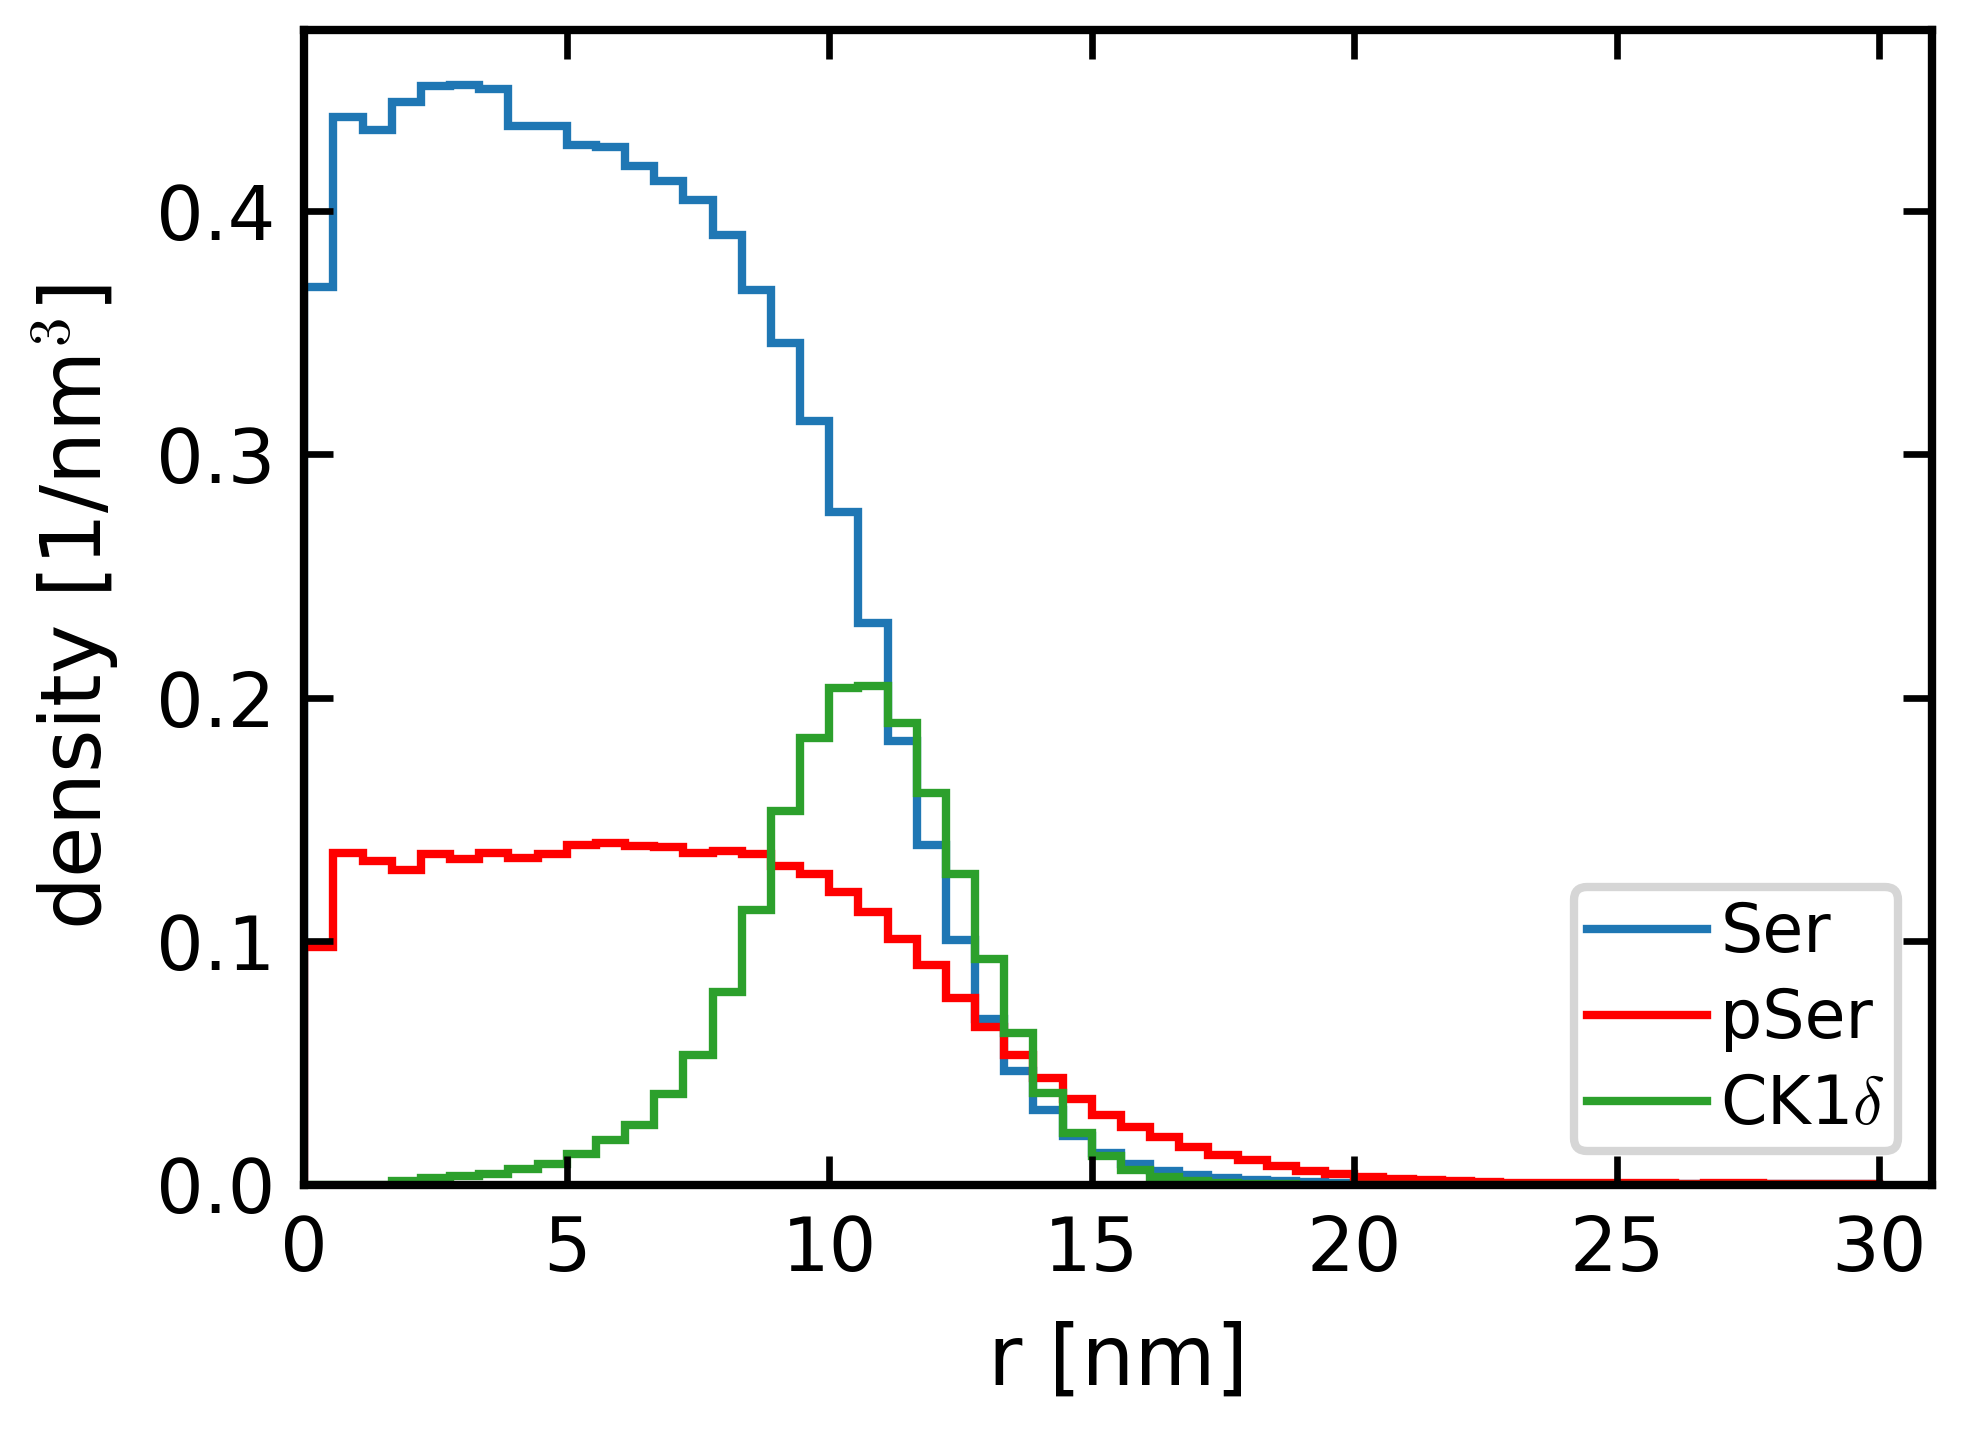

In [72]:
bin_edges = np.linspace(0,30,55)
fig, ax = plt.subplots(figsize=(3.5,2.5))

plt.stairs(counts_ser_40pcent, bin_edges, label='Ser')
plt.stairs(counts_pser_40pcent, bin_edges, color='r', label='pSer')
plt.stairs(counts_enz_40pcent, bin_edges, color='tab:green', label='CK1$\delta$')

plt.legend(loc='lower right')
plt.xlabel('r [nm]')
plt.ylabel('density [1/nm$^3$]')
plt.xlim(0,31)

(5e-05, 0.3)

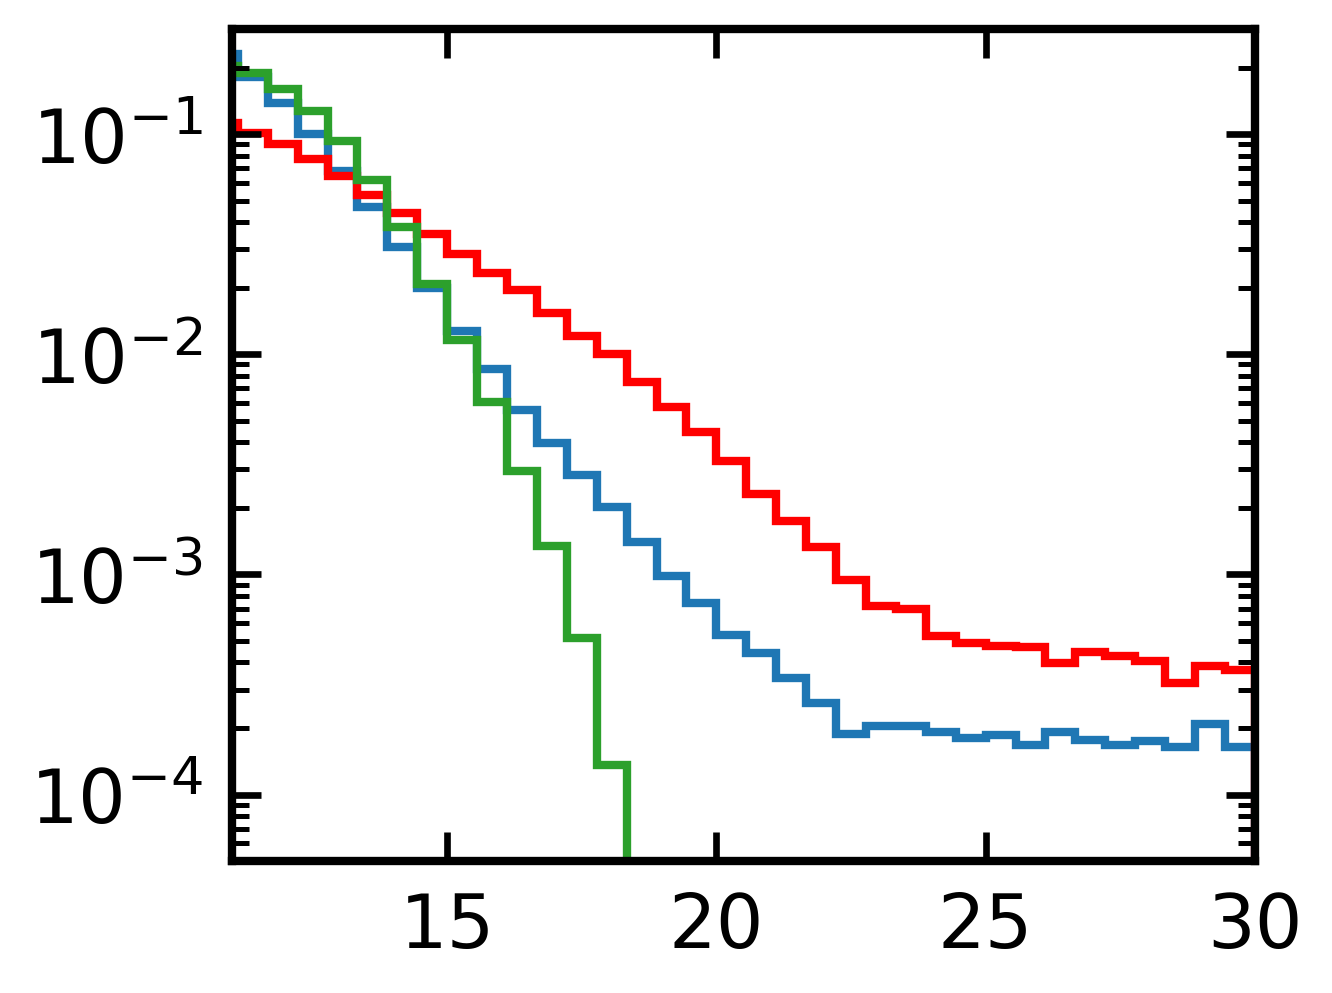

In [73]:
# INSET
fig, ax = plt.subplots(figsize=(2.2,1.8))

plt.stairs(counts_ser_40pcent, bin_edges, label='%Ser')
plt.stairs(counts_pser_40pcent, bin_edges, color='r', label='%pSer')
plt.stairs(counts_enz_40pcent, bin_edges, color='tab:green', label='%CK1$\delta$ beads')

plt.yscale('log')

plt.xlim(11,30)
plt.ylim(0.00005,0.3)

(0.0, 31.0)

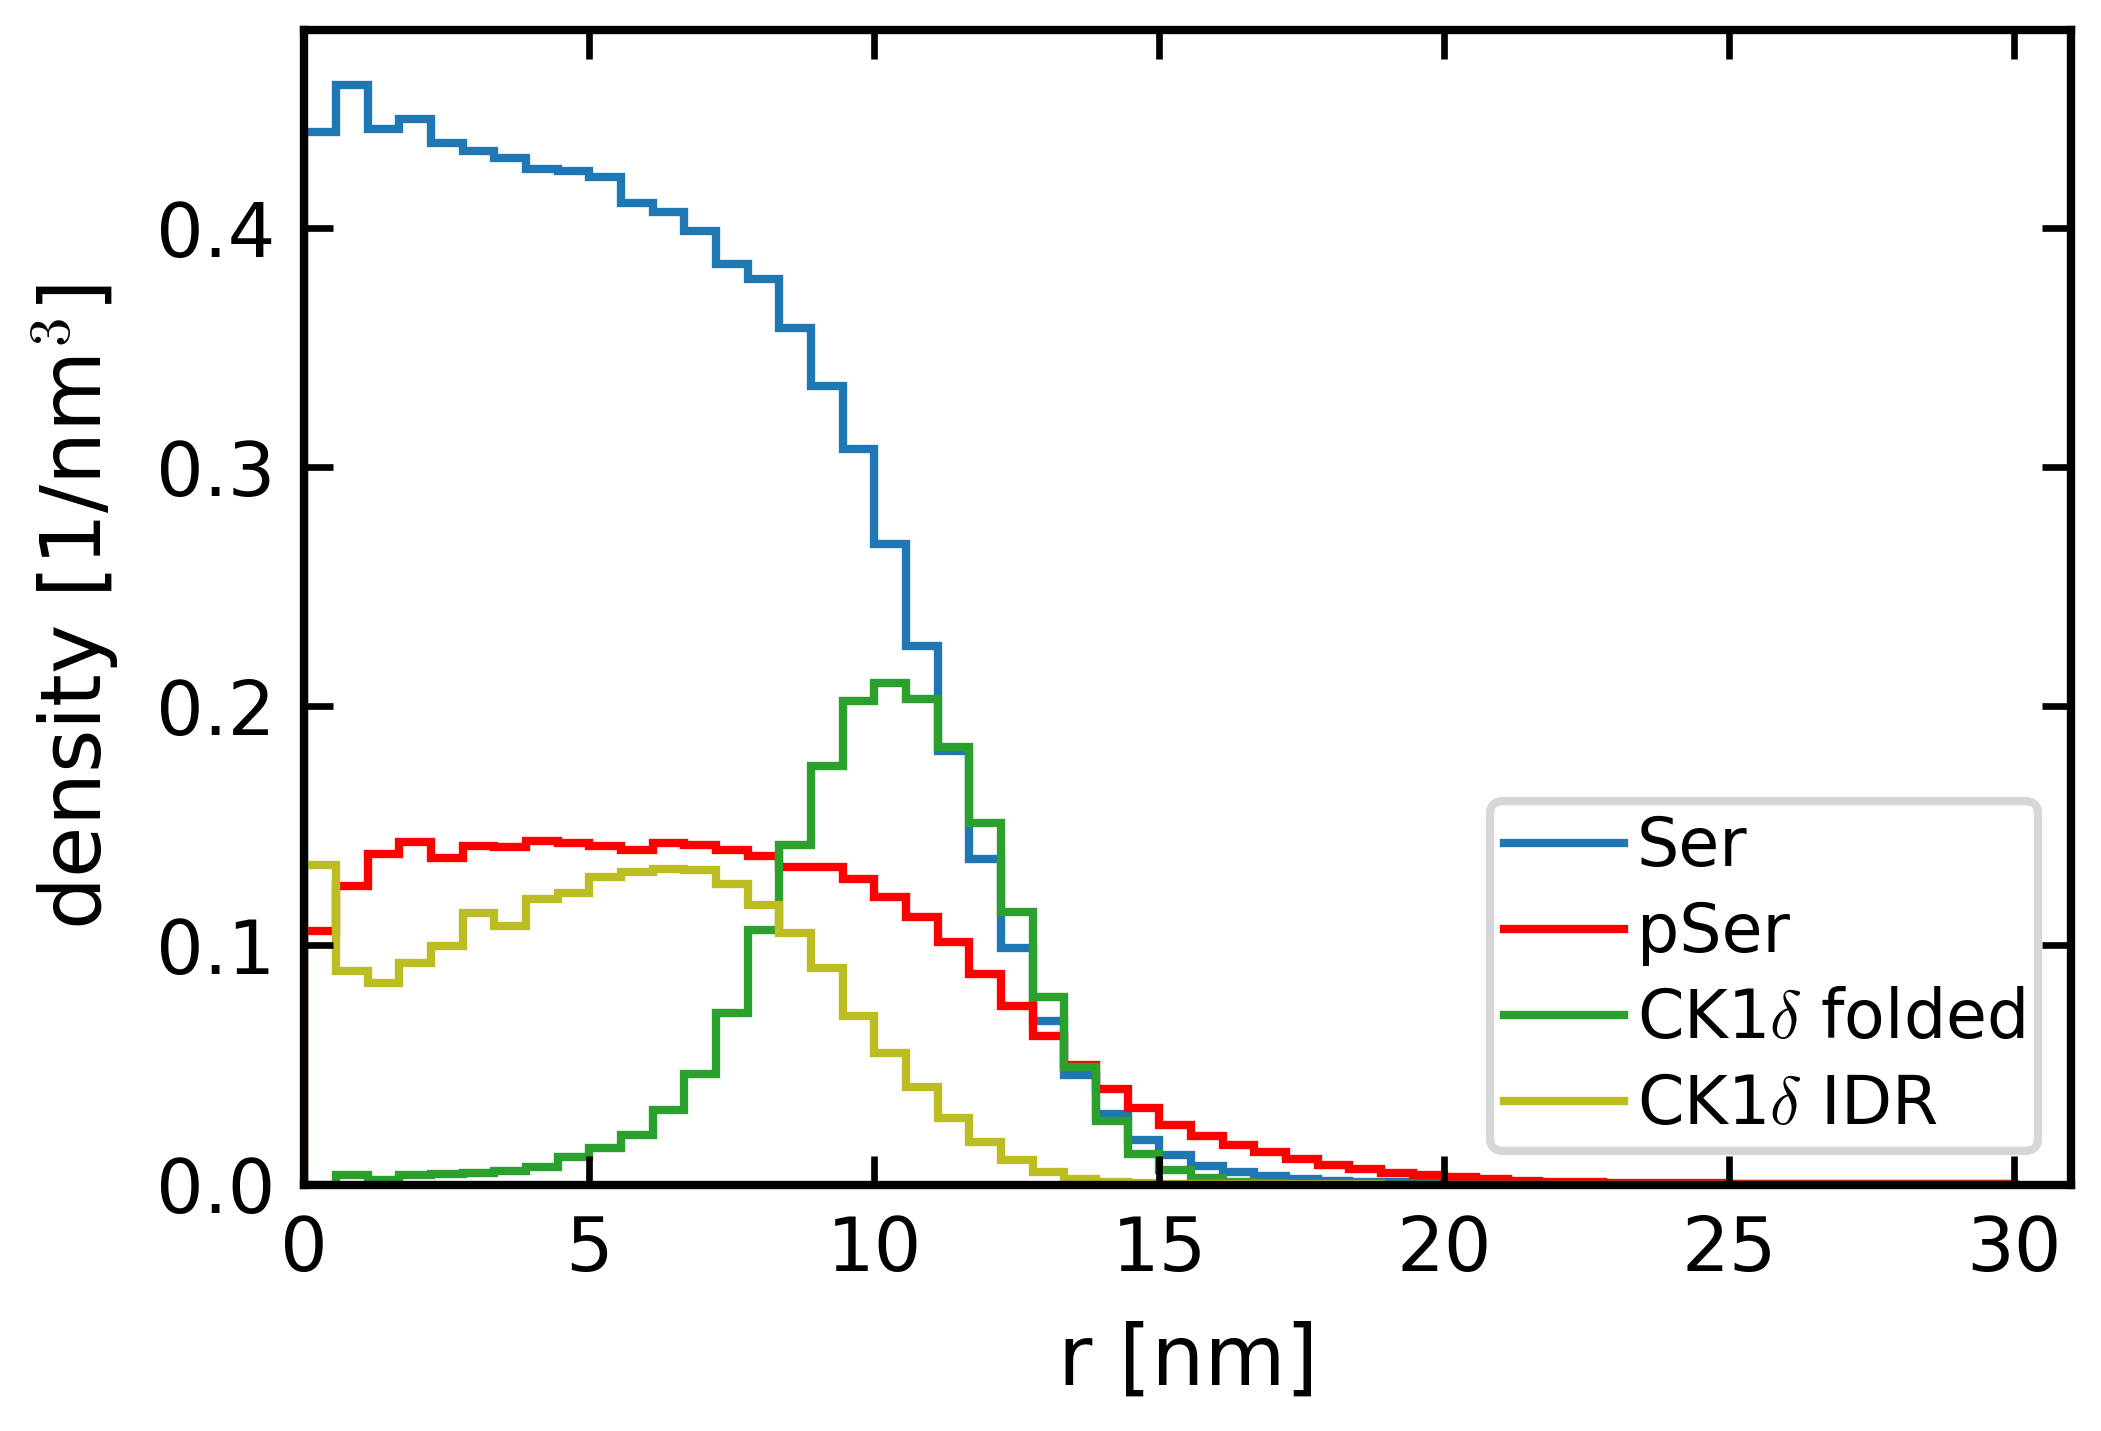

In [74]:
bin_edges = np.linspace(0,30,55)
fig, ax = plt.subplots(figsize=(3.8,2.5))

plt.stairs(counts_ser_eq_f, bin_edges, label='Ser')
plt.stairs(counts_pser_eq_f, bin_edges, color='r', label='pSer')
plt.stairs(counts_enz_eq_f, bin_edges, color='tab:green', label='CK1$\delta$ folded')
plt.stairs(counts_tail_eq_f, bin_edges, color='tab:olive', label='CK1$\delta$ IDR')
#plt.plot([-1,26],[(24*0.6*200)/(154*200+292*5)]*2, '--', c='tab:blue', label='%Ser uniform')
#plt.plot([-1,26],[(24*0.4*200)/(154*200+292*5)]*2, '--r', label='%pSer uniform')
plt.legend(loc='lower right')
plt.xlabel('r [nm]')
plt.ylabel('density [1/nm$^3$]')
plt.xlim(0,31)

(5e-05, 0.2)

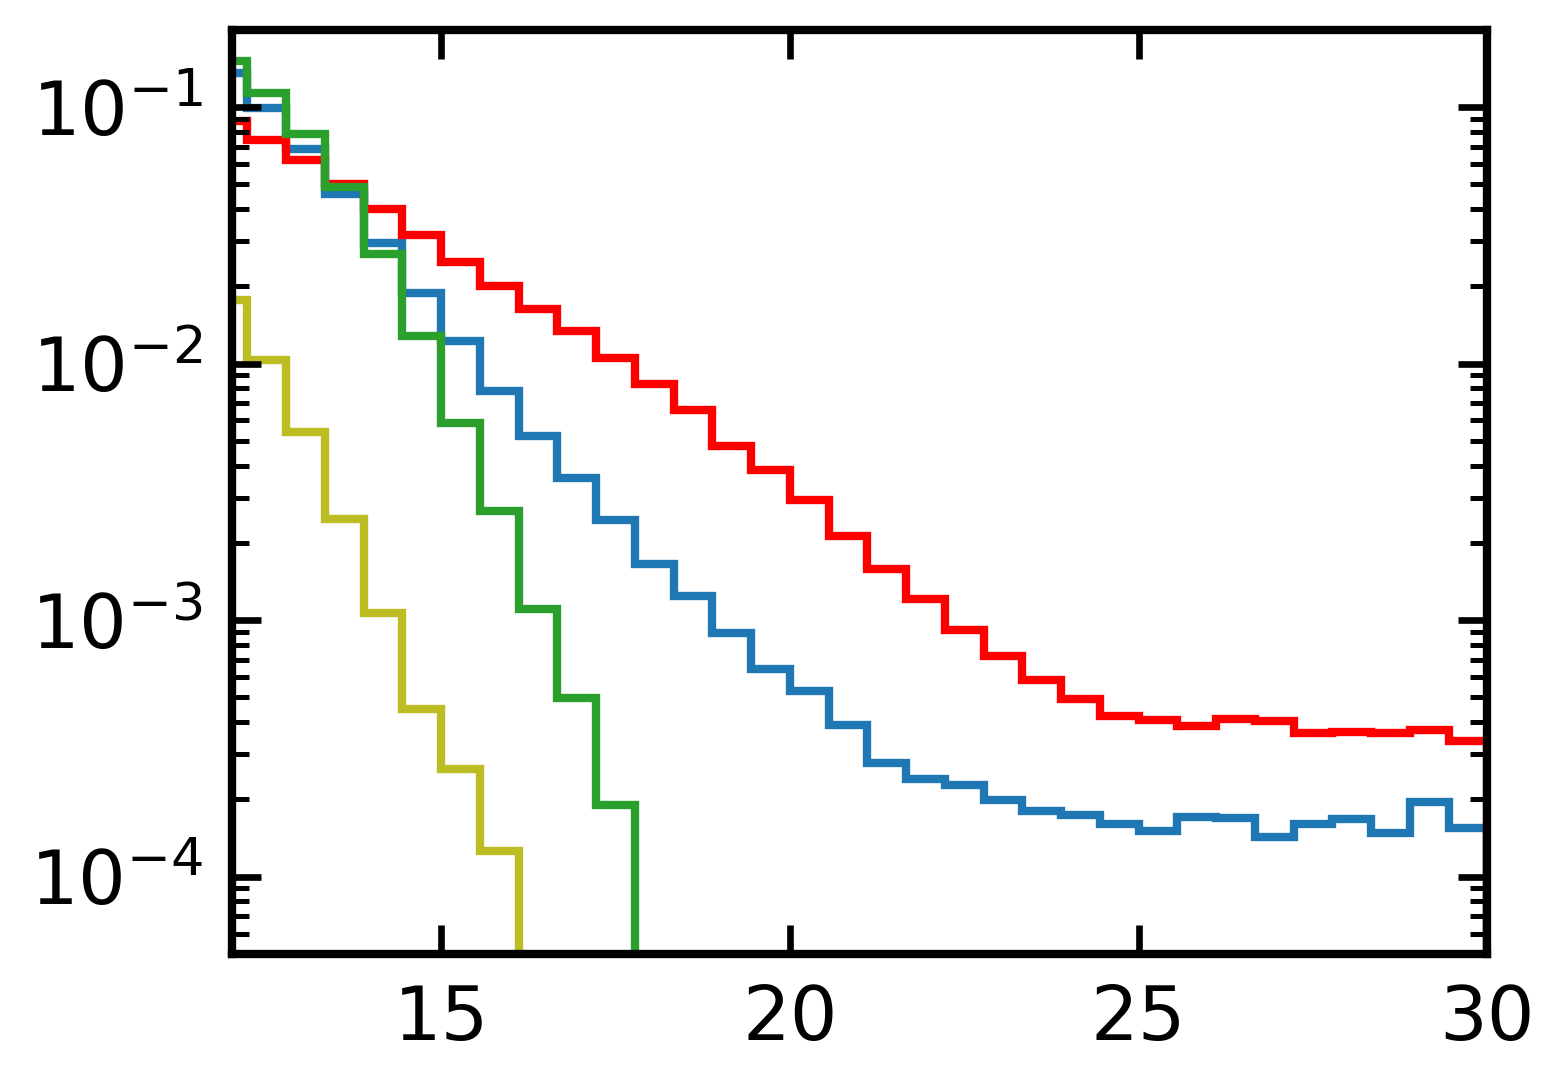

In [75]:
# INSET
fig, ax = plt.subplots(figsize=(2.7,2.0))

plt.stairs(counts_ser_eq_f, bin_edges)
plt.stairs(counts_pser_eq_f, bin_edges, color='r')
plt.stairs(counts_enz_eq_f, bin_edges, color='tab:green')
plt.stairs(counts_tail_eq_f, bin_edges, color='tab:olive')
#plt.plot([-1,26],[(24*0.6*200)/(154*200+292*5)]*2, '--', c='tab:blue', label='%Ser uniform')
#plt.plot([-1,26],[(24*0.4*200)/(154*200+292*5)]*2, '--r', label='%pSer uniform')
#plt.legend()
plt.yscale('log')
#plt.xlabel('r [nm]')
#plt.ylabel('density')
plt.xlim(12,30)
plt.ylim(0.00005,0.2)

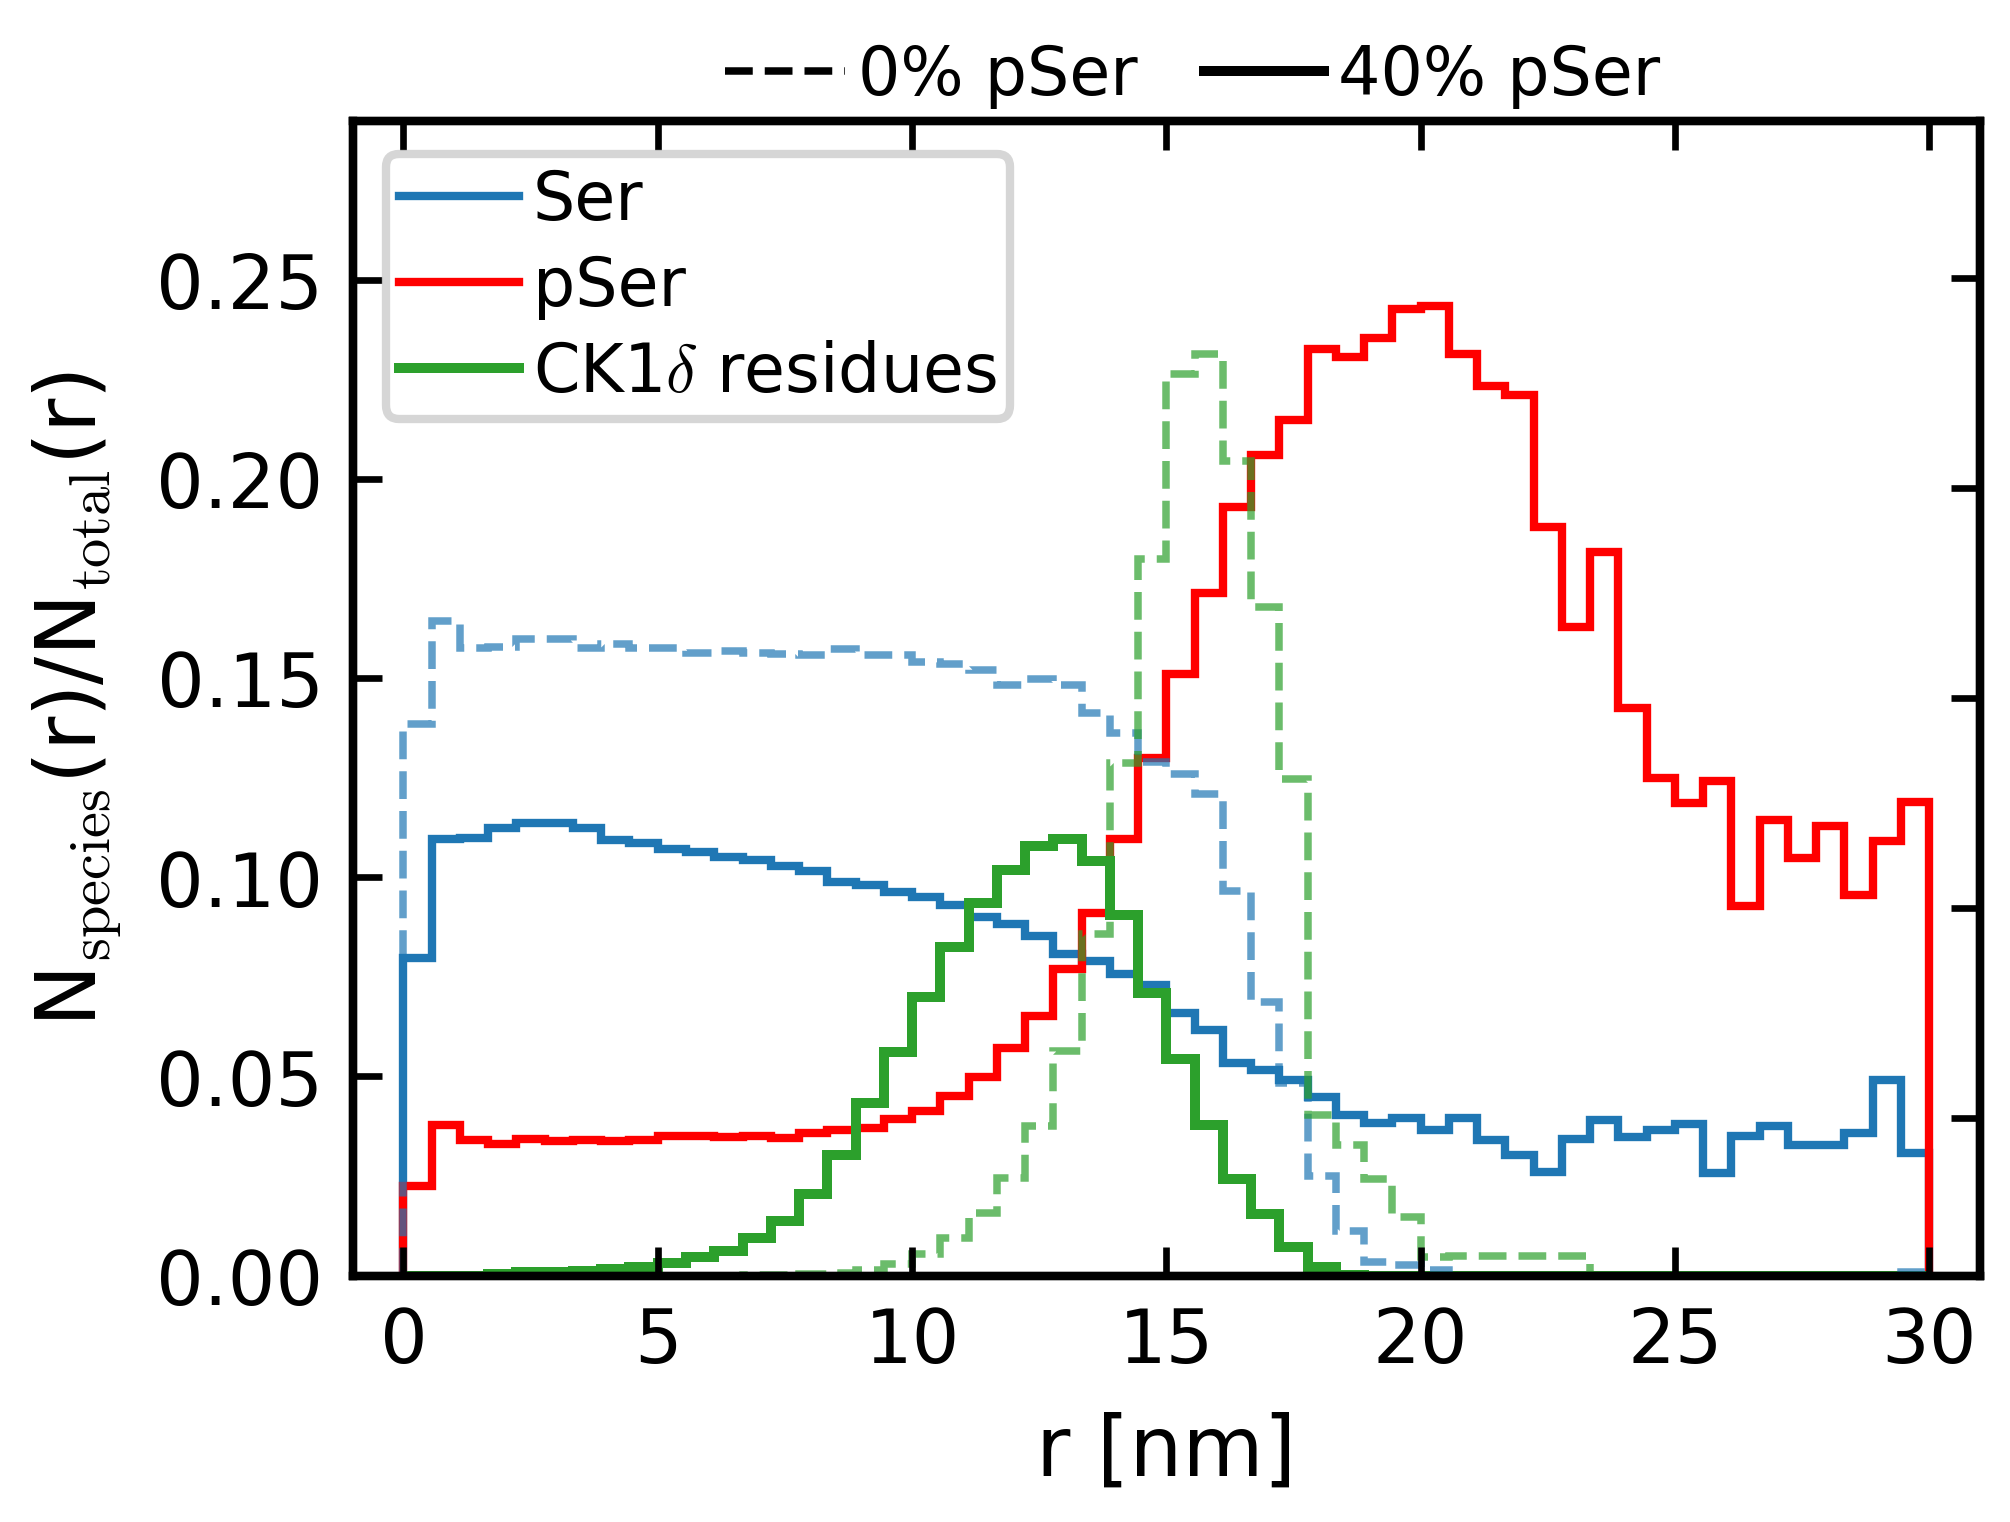

In [79]:
bin_edges = np.linspace(0,30,55)
fig, ax = plt.subplots(figsize=(3.5,2.5))

plt.stairs(counts_ser_40pcent_part, bin_edges, color='tab:blue',label='Ser', lw=1)
plt.stairs(counts_pser_40pcent_part, bin_edges, color='r', label='pSer', lw=1.)
plt.stairs(counts_enz_40pcent_part, bin_edges, color='tab:green', label='CK1$\delta$ residues', lw=1.2)
plt.stairs(counts_ser_eq_part, bin_edges,color='tab:blue',ls='--', alpha=0.7, lw=0.9)
plt.stairs(counts_pser_eq_part, bin_edges, color='r', ls='--', alpha=0.7, lw=0.9)
plt.stairs(counts_enz_eq_part, bin_edges, color='tab:green', ls='--', alpha=0.7, lw=0.9)
#plt.plot([-1,26],[(24*0.6*200)/(154*200+292*5)]*2, '--', c='tab:blue', label='%Ser uniform')
#plt.plot([-1,26],[(24*0.4*200)/(154*200+292*5)]*2, '--r', label='%pSer uniform')
plt.legend()
plt.xlabel('r [nm]')
plt.ylabel(r'N$_\mathrm{species}$(r)/N$_\mathrm{total}$(r)')
plt.xlim(-1,31)
plt.ylim(0,0.29)

ax1= ax.twinx()
ax1.tick_params(labelright=False)
ax1.plot([],[], ls='--',c='k', lw=0.9, label=r'0% pSer')
ax1.plot([],[], ls='-', c='k', lw=1.2, label=r'40% pSer')
ax1.legend(loc='lower left', bbox_to_anchor=(0.2,0.97,0.5,0.5), frameon=False, ncols=2, fontsize=8 )

Text(15, 0.45, ' 0% rescaling \n of rigid body')

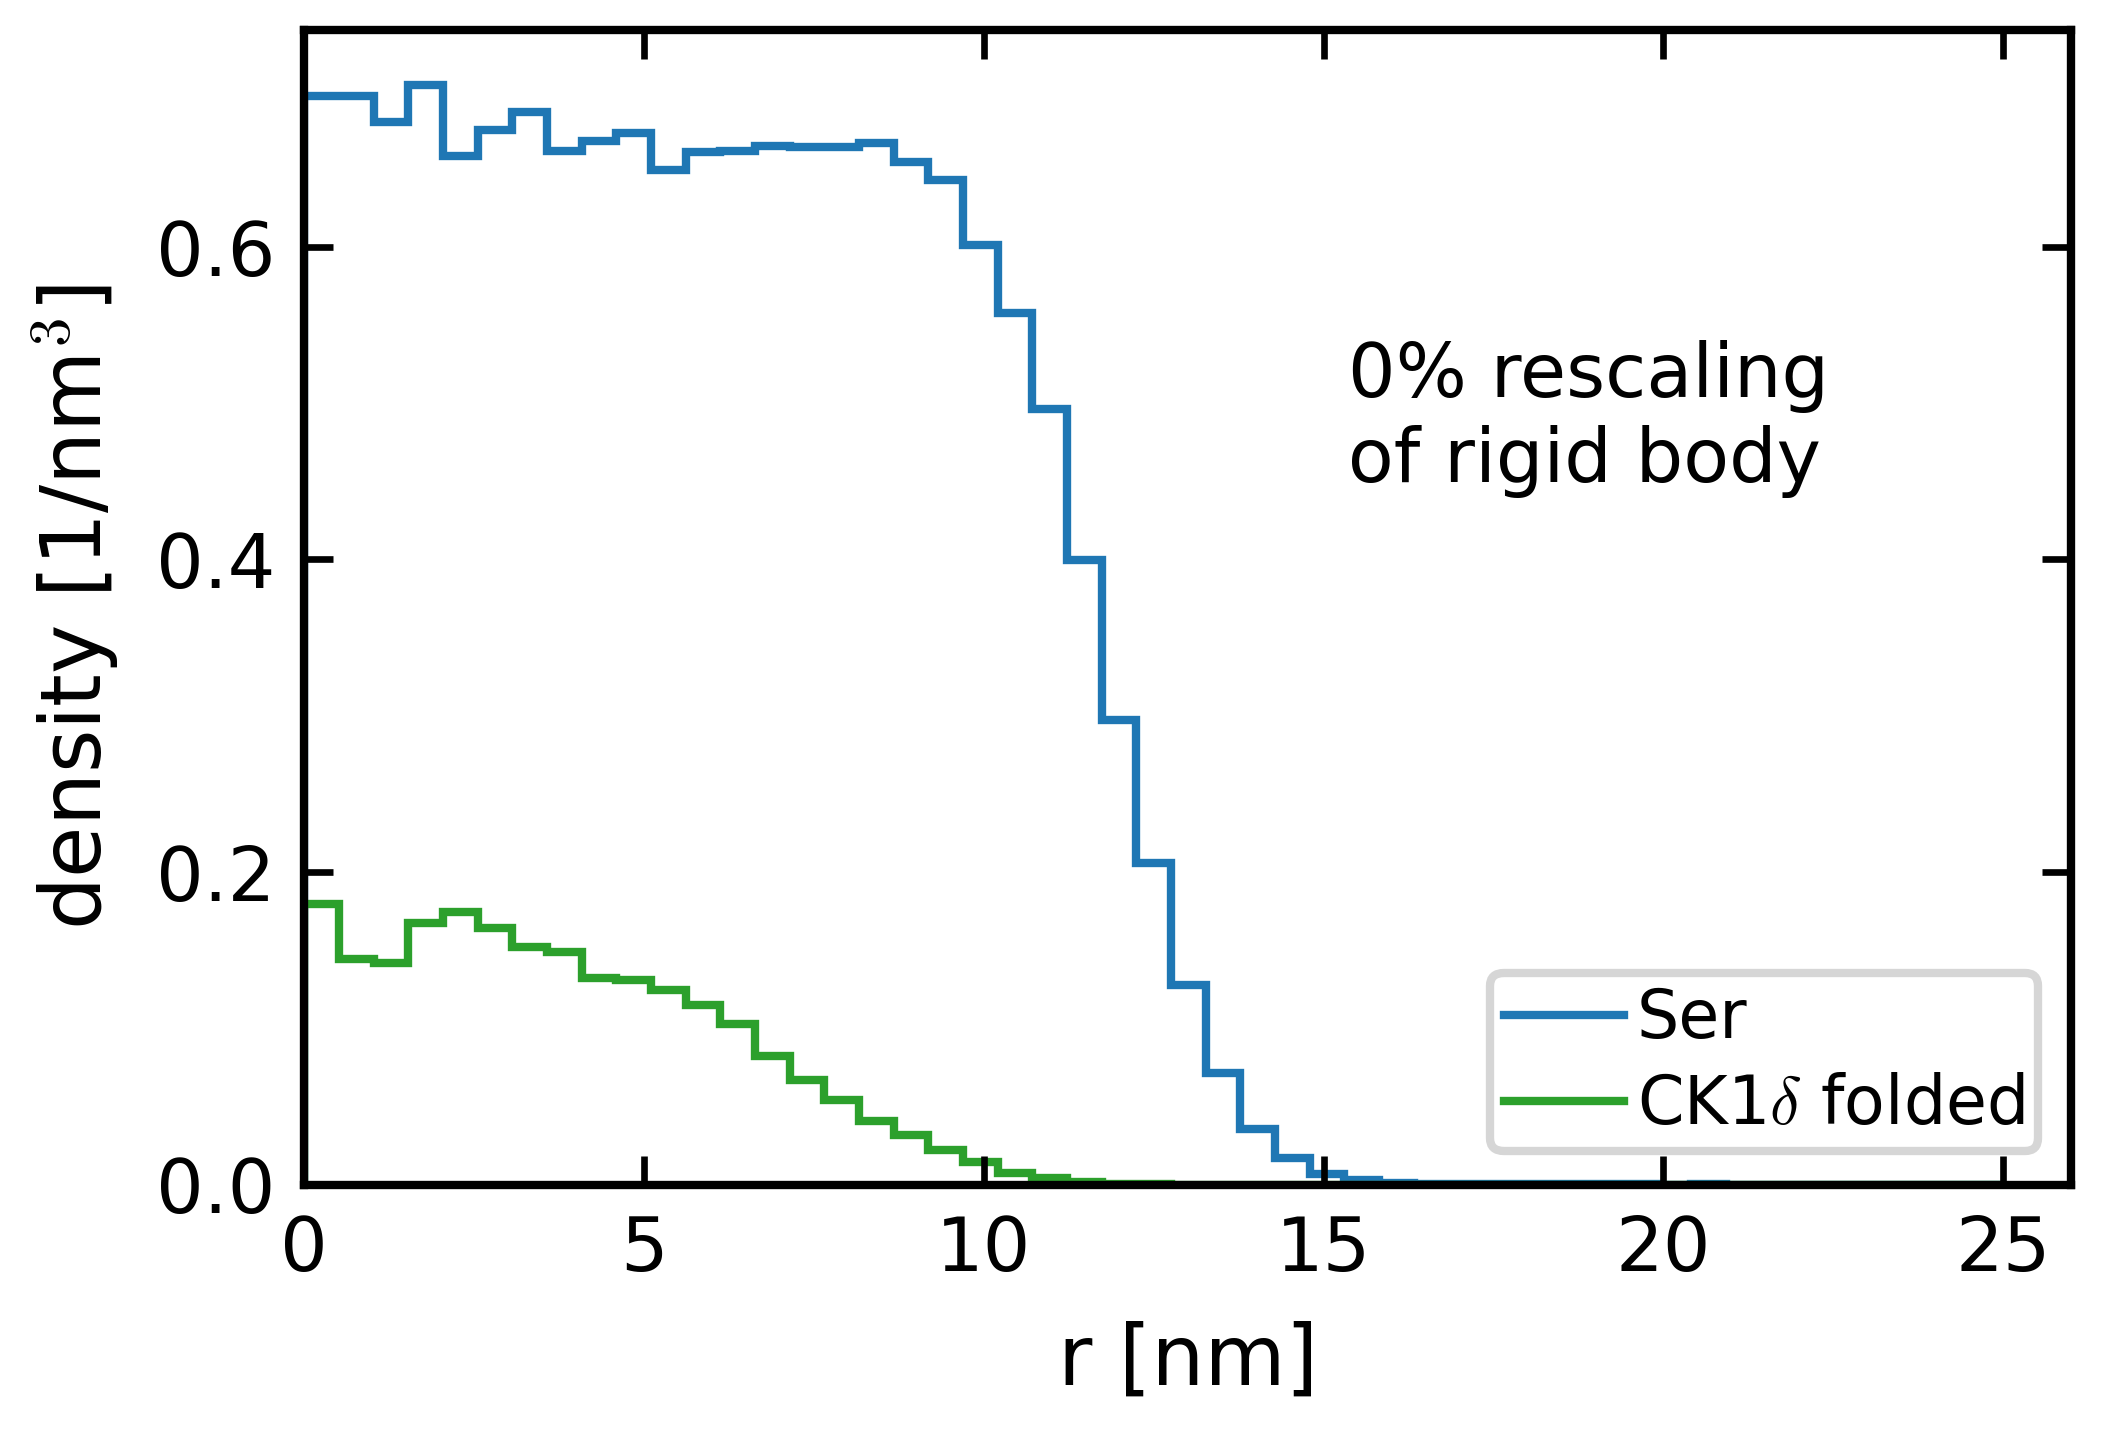

In [77]:
bin_edges = np.linspace(0,25,50)
fig, ax = plt.subplots(figsize=(3.8,2.5))

plt.stairs(counts_ser_in, bin_edges, label='Ser')

plt.stairs(tmp_counts_enz_in, bin_edges, color='tab:green', label='CK1$\delta$ folded')
plt.legend(loc='lower right')
plt.xlabel('r [nm]')
plt.ylabel('density [1/nm$^3$]')
plt.xlim(0,26)
plt.text(15,0.45,' 0% rescaling \n of rigid body', fontsize=9)

## Phosphorylated serines per chain in dilute phase

In [88]:
npdil_5ck1d_list, npdil_5ck1d, dpdil_5ck1d, nchainsdil_5ck1d = pSer_dilute(file+f'sim1_5-folded-ck1d_multi-tdp43_32b_dump_processed.gsd', times_dis, eps=1.0, min_sample=2)


2500


  0%|                                                                                                                                                                                       | 0/40 [00:00<?, ?it/s]

500


/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encoun

n chains dilute: 0
550


  5%|████████▊                                                                                                                                                                      | 2/40 [00:00<00:17,  2.14it/s]

n chains dilute: 1
600


/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/localscratch/zippoema/lib/python_envs/md_analysis_env/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encoun

n chains dilute: 0
650


 10%|█████████████████▌                                                                                                                                                             | 4/40 [00:01<00:16,  2.14it/s]

n chains dilute: 1
700


 12%|█████████████████████▉                                                                                                                                                         | 5/40 [00:02<00:16,  2.16it/s]

n chains dilute: 1
750


 15%|██████████████████████████▎                                                                                                                                                    | 6/40 [00:02<00:15,  2.21it/s]

n chains dilute: 1
800


 18%|██████████████████████████████▌                                                                                                                                                | 7/40 [00:03<00:14,  2.27it/s]

n chains dilute: 5
850


 20%|███████████████████████████████████                                                                                                                                            | 8/40 [00:03<00:14,  2.28it/s]

n chains dilute: 5
900


 22%|███████████████████████████████████████▍                                                                                                                                       | 9/40 [00:04<00:13,  2.25it/s]

n chains dilute: 9
950


 25%|███████████████████████████████████████████▌                                                                                                                                  | 10/40 [00:04<00:13,  2.30it/s]

n chains dilute: 14
1000


 28%|███████████████████████████████████████████████▊                                                                                                                              | 11/40 [00:04<00:12,  2.31it/s]

n chains dilute: 15
1050


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 12/40 [00:05<00:11,  2.34it/s]

n chains dilute: 21
1100


 32%|████████████████████████████████████████████████████████▌                                                                                                                     | 13/40 [00:05<00:11,  2.39it/s]

n chains dilute: 22
1150


 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 14/40 [00:06<00:11,  2.36it/s]

n chains dilute: 21
1200


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 15/40 [00:06<00:10,  2.41it/s]

n chains dilute: 20
1250


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 16/40 [00:06<00:09,  2.45it/s]

n chains dilute: 33
1300


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                    | 17/40 [00:07<00:10,  2.16it/s]

n chains dilute: 40
1350


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                               | 18/40 [00:08<00:10,  2.11it/s]

n chains dilute: 46
1400


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 19/40 [00:08<00:09,  2.27it/s]

n chains dilute: 57
1450


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 20/40 [00:08<00:08,  2.40it/s]

n chains dilute: 65
1500


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 21/40 [00:09<00:07,  2.42it/s]

n chains dilute: 64
1550


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 22/40 [00:09<00:07,  2.48it/s]

n chains dilute: 67
1600


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 23/40 [00:09<00:06,  2.59it/s]

n chains dilute: 87
1650


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 24/40 [00:10<00:06,  2.64it/s]

n chains dilute: 88
1700


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 25/40 [00:10<00:05,  2.65it/s]

n chains dilute: 83
1750


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 26/40 [00:10<00:05,  2.69it/s]

n chains dilute: 102
1800


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 27/40 [00:11<00:04,  2.75it/s]

n chains dilute: 103
1850


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28/40 [00:11<00:04,  2.79it/s]

n chains dilute: 130
1900


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29/40 [00:11<00:03,  2.89it/s]

n chains dilute: 143
1950


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30/40 [00:12<00:03,  2.95it/s]

n chains dilute: 140
2000


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31/40 [00:12<00:02,  3.03it/s]

n chains dilute: 161
2050


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32/40 [00:12<00:02,  3.03it/s]

n chains dilute: 173
2100


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 33/40 [00:13<00:02,  3.06it/s]

n chains dilute: 168
2150


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 34/40 [00:13<00:01,  3.14it/s]

n chains dilute: 175
2200


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 35/40 [00:13<00:01,  3.17it/s]

n chains dilute: 181
2250


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 36/40 [00:14<00:01,  3.20it/s]

n chains dilute: 183
2300


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 37/40 [00:14<00:00,  3.22it/s]

n chains dilute: 186
2350


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 38/40 [00:14<00:00,  3.28it/s]

n chains dilute: 186
2400


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 39/40 [00:15<00:00,  3.32it/s]

n chains dilute: 186
2450


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.60it/s]

n chains dilute: 182


Text(0.5, 1.0, '$N_{pSer}$(t>2.5$\\mu$s)=16.2(3)')

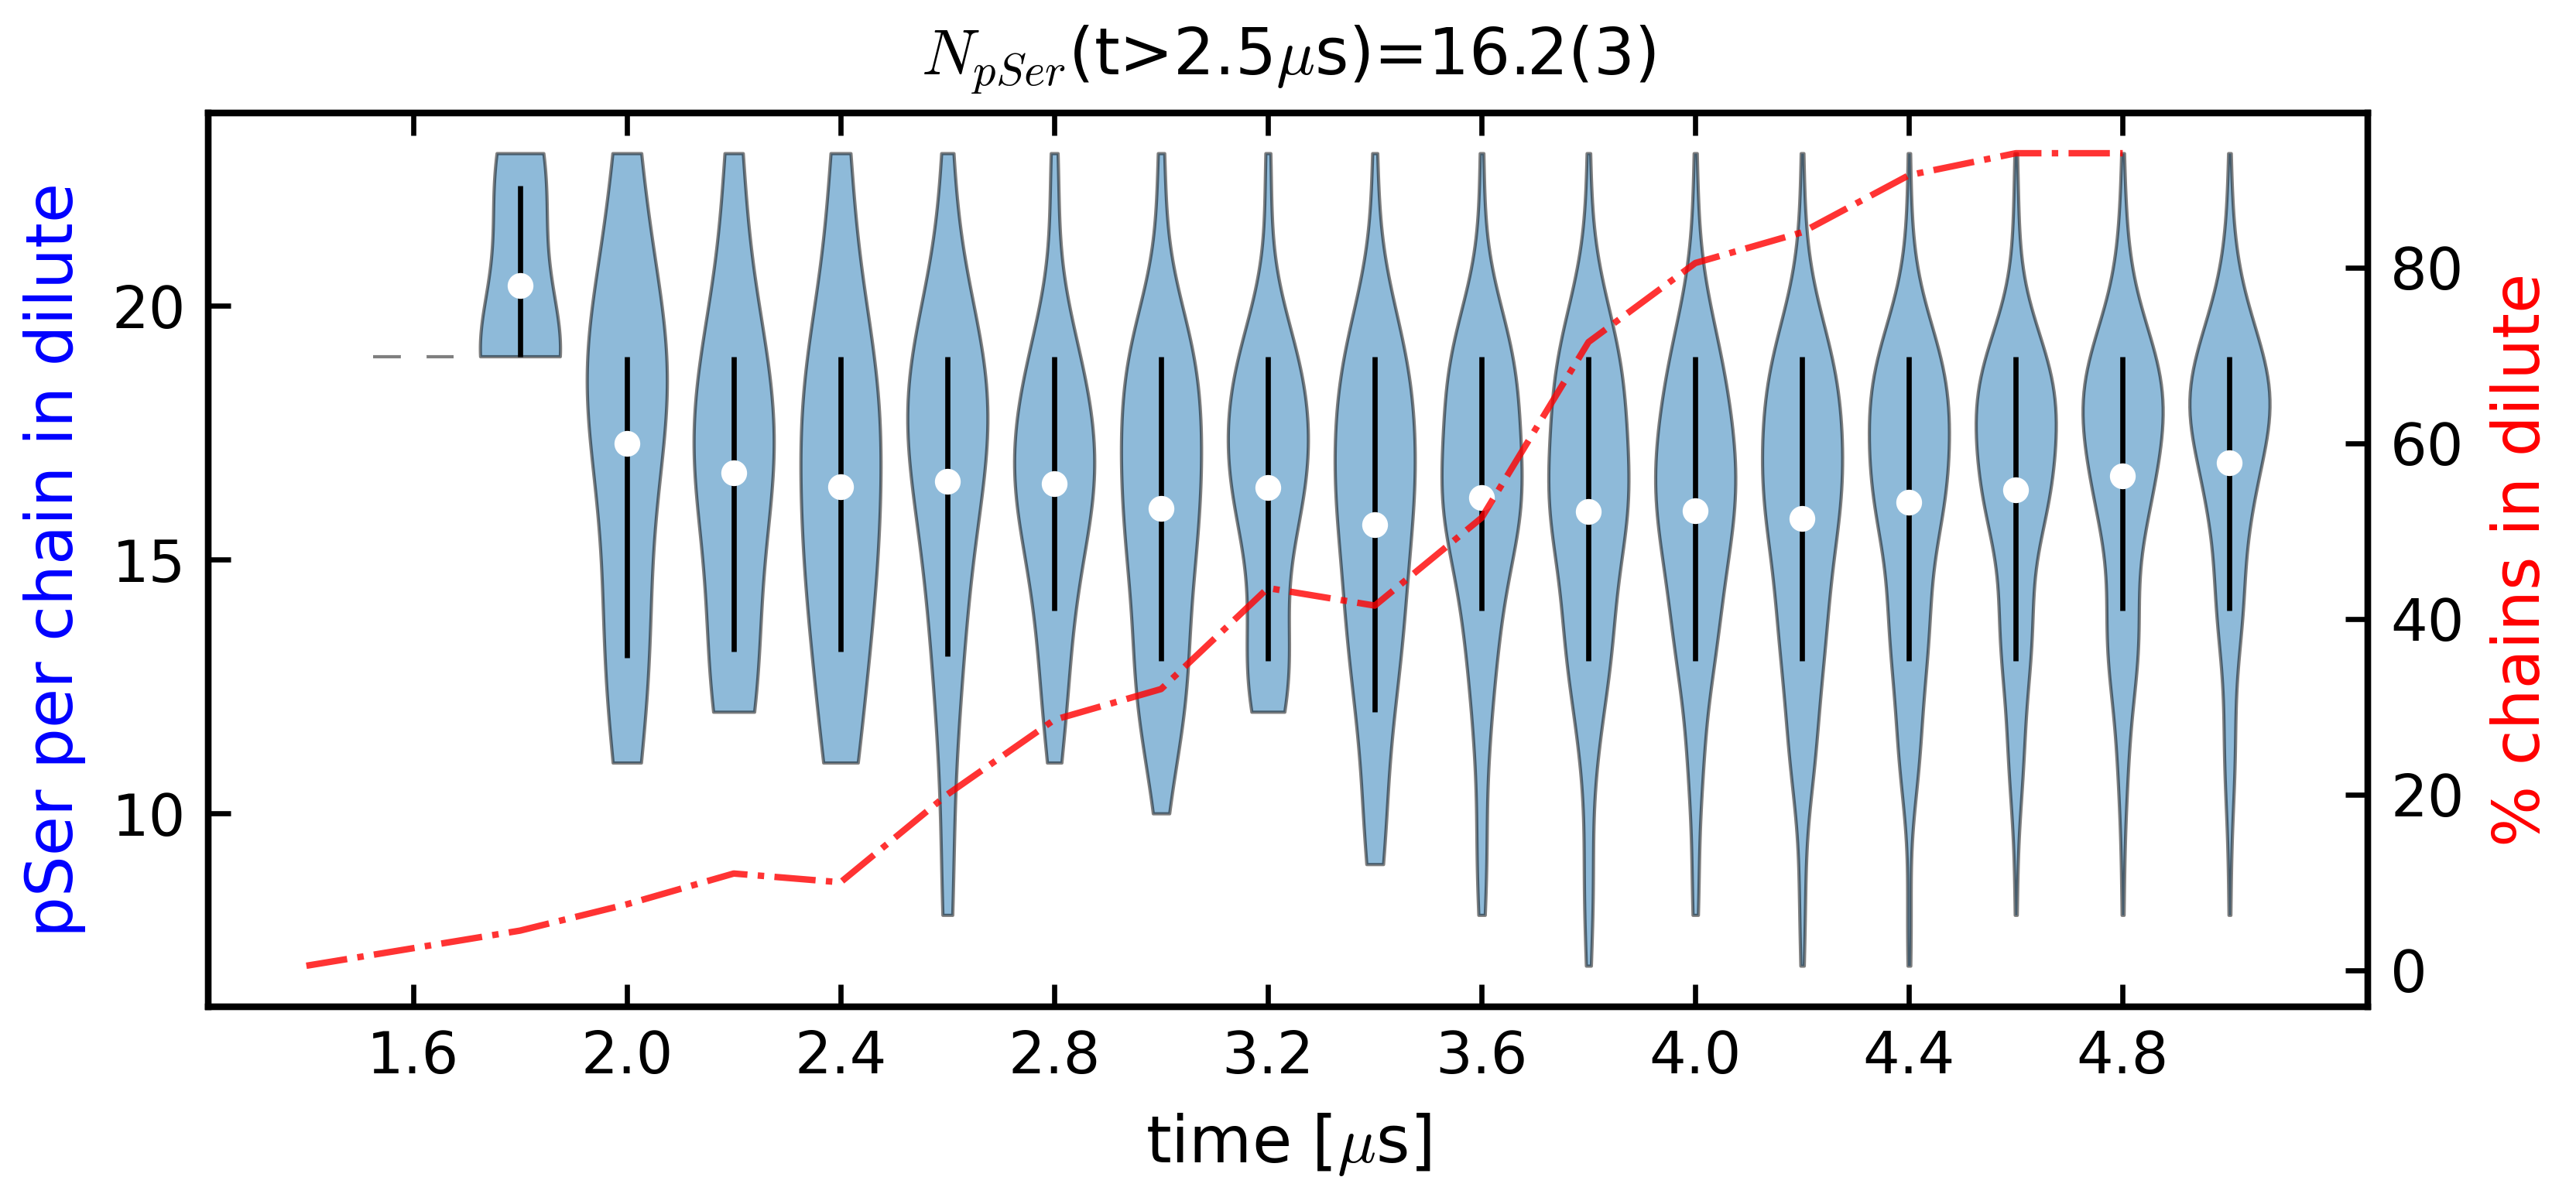

In [89]:
time_step_dis = times_dis*200000

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

fig, ax1 = plt.subplots(figsize=(6, 2.5))
 
# Plot the first array with the primary y-axis
data = npdil_5ck1d_list[5::2]
parts = ax1.violinplot(
        data, widths=0.75, 
        showmeans=False, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    pc.set_lw(0.5)

percentile1 = [ np.percentile(data[i], 15.9) for i in range(len(data)) ]
percentile3 = [ np.percentile(data[i], 84.1) for i in range(len(data)) ]

inds = np.arange(1, len(data) + 1)
ax1.vlines(inds, percentile1, percentile3, color='k', linestyle='-', lw=0.8)
ax1.scatter(inds, npdil_5ck1d[5::2], marker='o', color='white', zorder=3)

ax1.set_xlabel('time [$\mu$s]')
ax1.set_ylabel('pSer per chain in dilute', color='b')
ax1.set_xticks(np.arange(1, len(data)+1, 2), [1.6, 2.0, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8])

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(nchainsdil_5ck1d[4::2]/2, 'r-.', alpha=0.8)
ax2.set_ylabel('% chains in dilute', color='r')

plt.title(r'$N_{pSer}$(t>2.5$\mu$s)='+f'{np.mean(npdil_5ck1d[15:]):.1f}({np.std(npdil_5ck1d[15:])*10:.0f})', fontsize=10)


## Distance enzyme-condensate 

In [82]:
path=''

dist1 = distance_particle_from_condensate(path+'sim1_5-folded-ck1d_multi-tdp43_40pcent_pSer_ck1d-out_dump_processed.gsd', times_sh, part_idx=30804)
dist2 = distance_particle_from_condensate(path+'sim2_5-folded-ck1d_multi-tdp43_40pcent_pSer_ck1d-out_dump_processed.gsd', times_sh, part_idx=30804)
dist3 = distance_particle_from_condensate(path+'sim3_5-folded-ck1d_multi-tdp43_40pcent_pSer_ck1d-out_dump_processed.gsd', times_sh, part_idx=30804)
dist4 = distance_particle_from_condensate(path+'sim4_5-folded-ck1d_multi-tdp43_40pcent_pSer_ck1d-out_dump_processed.gsd', times_sh, part_idx=30804)
dist5 = distance_particle_from_condensate(path+'sim5_5-folded-ck1d_multi-tdp43_40pcent_pSer_ck1d-out_dump_processed.gsd', times_sh, part_idx=30804)

500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.89it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.85it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


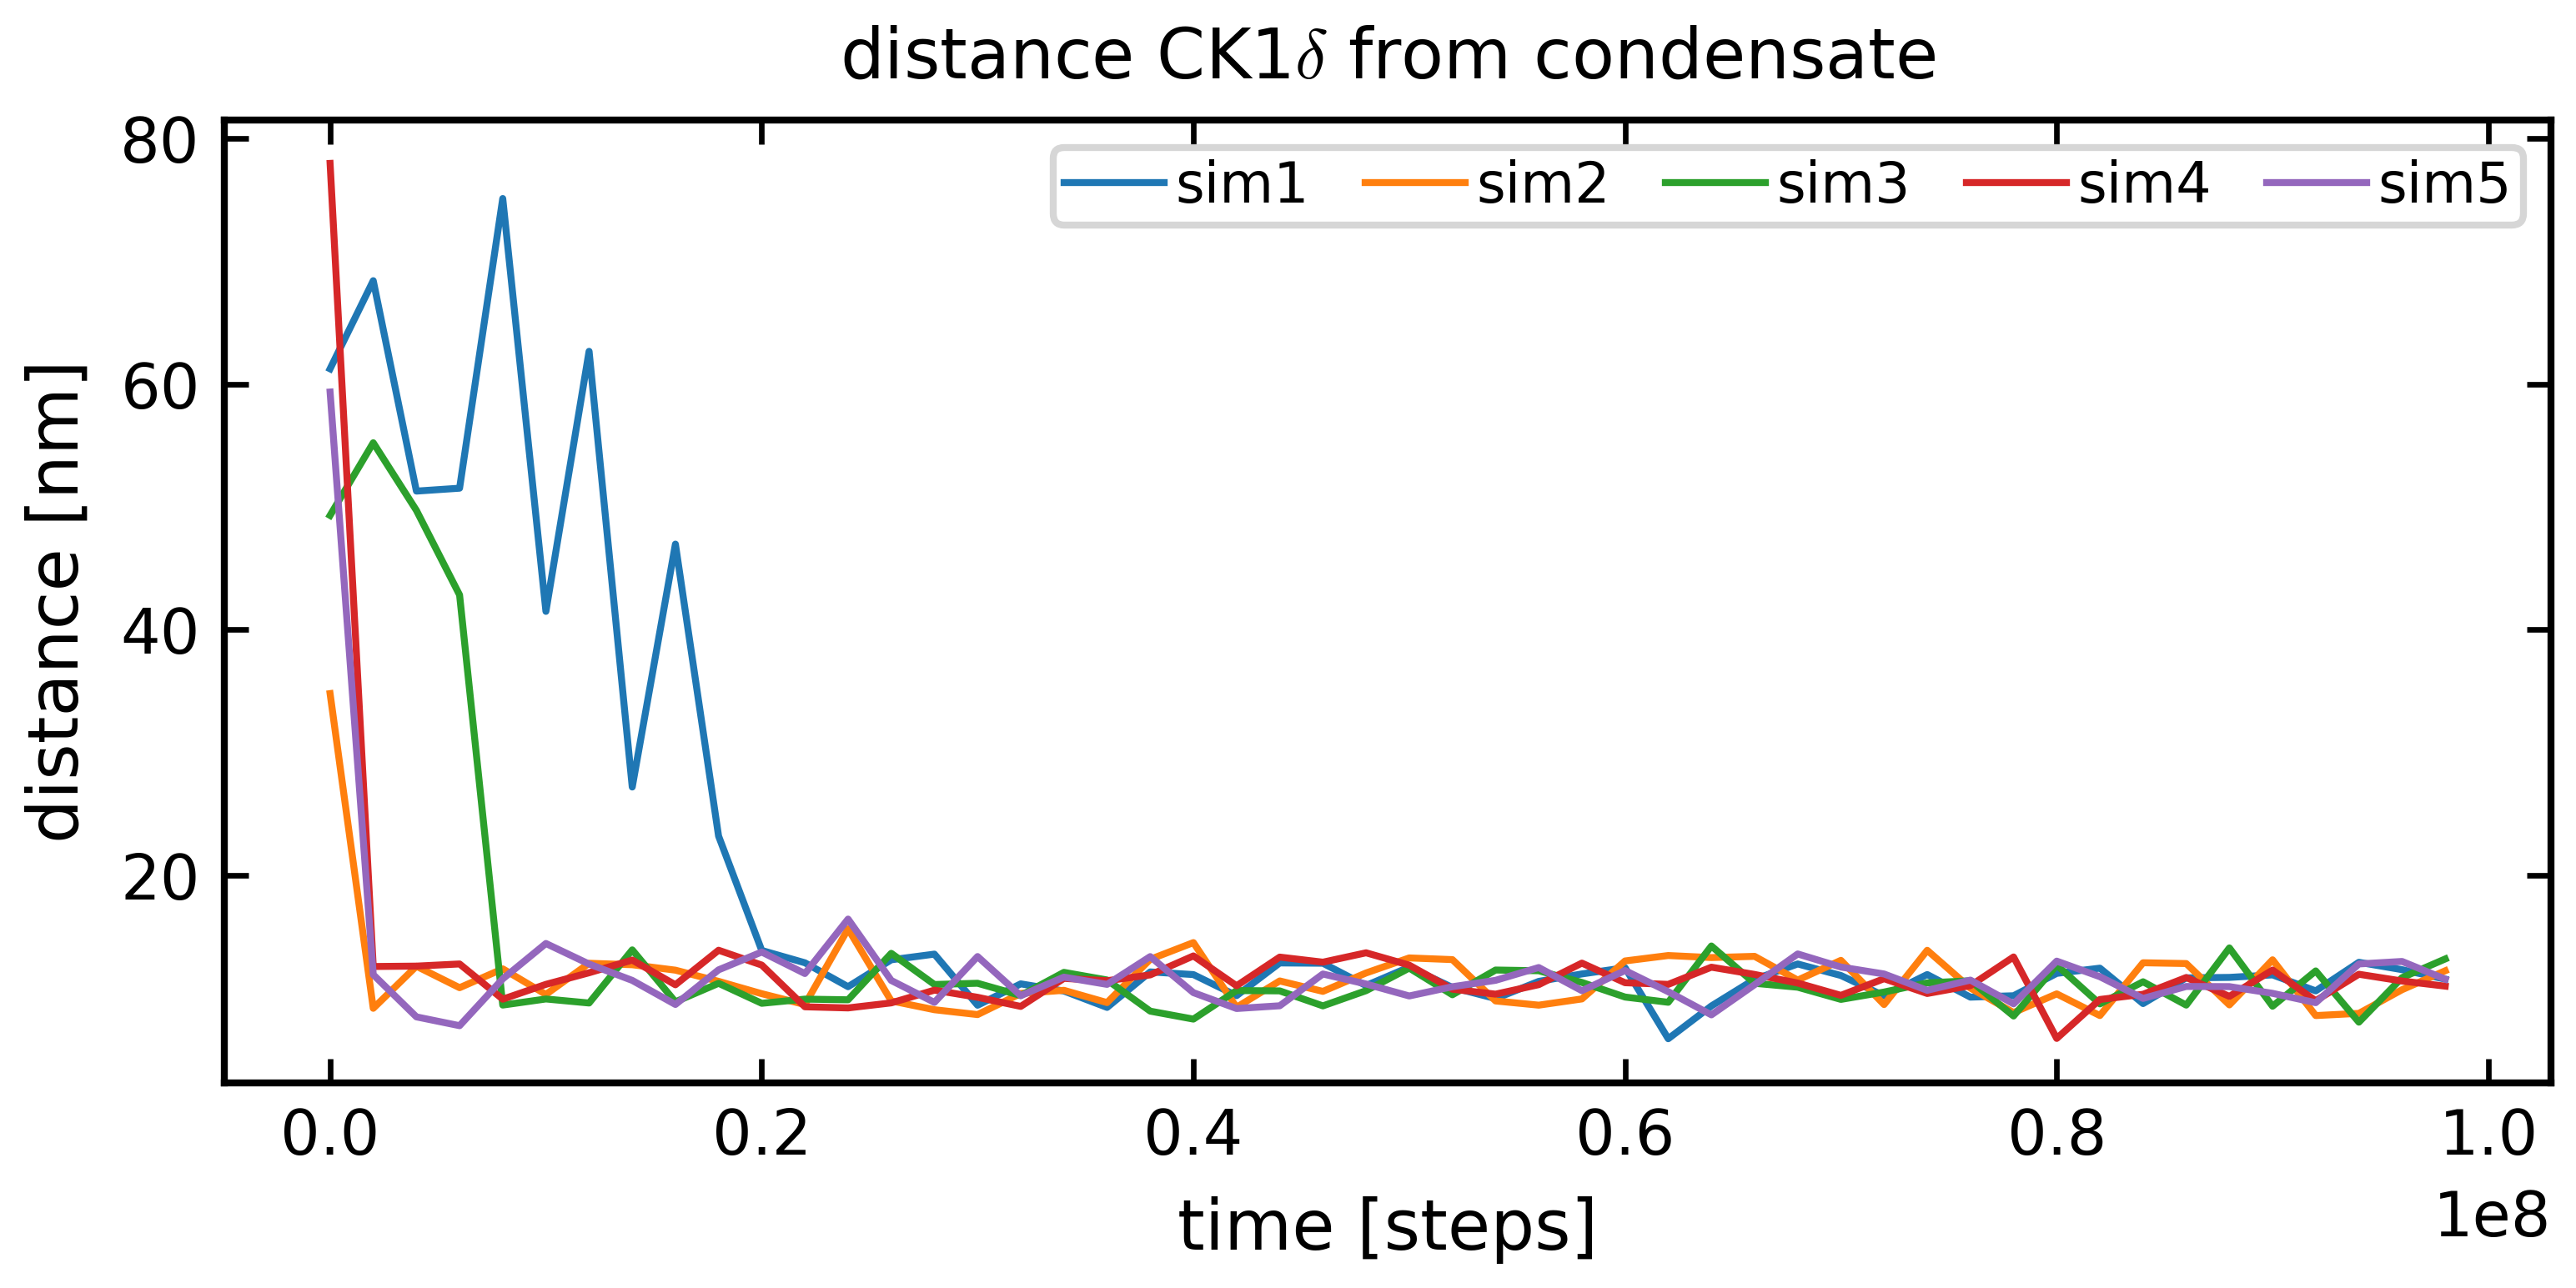

In [83]:
time_step = np.array(times_sh)*200000

fig, ax1 = plt.subplots(figsize=(6, 2.5))
plt.title("distance CK1$\delta$ from condensate", fontsize=10)

# Plot the first array with the primary y-axis
ax1.plot(time_step, dist1, label='sim1')
ax1.plot(time_step, dist2, label='sim2')
ax1.plot(time_step, dist3, label='sim3')
ax1.plot(time_step, dist4, label='sim4')
ax1.plot(time_step, dist5, label='sim5')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('distance [nm]')

ax1.legend(ncols=10)